In [1]:
knitr::opts_chunk$set(echo = FALSE)

# Bayesian Applications

By Pat Reen - originally published on his GitHub site [here](https://pat-reen.github.io/More-Modelling-Recipes/), which has the [original code](https://github.com/Pat-Reen/More-Modelling-Recipes).

# Background

Bayesian statistics reflects uncertainty about model parameters by assuming some prior probability distribution for those parameters. That prior uncertainty is adjusted for observed data to produce a posterior distribution.

Under a frequentest approach, model parameters are fixed and the observations are assumed to be sampled from a probability distribution with those parameters.

[Bayes theorem refresher](https://en.wikipedia.org/wiki/Bayes%27_theorem):

$\Huge {p}(\theta,x) = \frac{{p}(x,\theta){p}(\theta)}{{p}(x)}$

Where 

* ${p}(\theta,x)$ is the posterior, a combination of the likelihood, prior and evidence. Probability distribution of $\theta$ given the observed data, $x$.  
* ${p}(x,\theta)$ is the likelihood which summarizes the likelihood of observing data $x$ under different values of the underlying support parameter $\theta$.  
* ${p}(\theta)$ is the prior, the probability distribution of $\theta$, independent of the observed data.
* ${p}(x)$ is the evidence (normalising term), the probability of the observed data $x$, independent of $\theta$.

The evidence term is proportional to the likelihood and therefore the theorem is often stated as

$\Huge p(\theta | x) \propto p(x | \theta) p(\theta)$

A paper presented at the 2021 Actuaries (Institute) Summit @Latent (p2) sets out the 'tensions' that exist between Frequentest and Bayesian approaches and suggests that:

> "Despite actuaries being pioneers in early work on credibility theory, Bayesian approaches have largely given way to frequentist approaches. This is to our loss, since such methods have advanced substantially over the past couple of decades and they are well-suited to problems with latent variables or noise around underlying ‘true’ values."

Here we'll look at a few simple applications of Bayesian techniques.

# Applications
The sections below set out a simple example Bayesian refresher, regression models and other applications.

## Libraries
A list of packages used in the recipes.

In [2]:
library(base)         # Base r functions
library(fitdistrplus) # Fit of univariate distributions to non-censored data
library(lubridate)    # tidyverse: dealing with dates
library(ggplot2)      # tidyverse: graphs
library(gridExtra)    # tidyverse: arranging graphs
library(ggthemes)     # tidyverse: additional themes for ggplot, optional
library(dplyr)        # tidyverse: data manipulation
library(tidyr)        # tidyverse: tidy messy data
library(broom)        # tidyverse: visualising statistical objects
library(DataExplorer) # package for exploratory data analysis
library(scales)       # data formatting
library(stats)        # statistical functions
library(rstan)        # interface for stan platform
library(bayesplot)    # Plotting bayesian models (ggplot extension)
library(rjags)        # alternative interface for stan platform, regression applications
# library(EpiNow2)    # epidemiological model with stan backend; not called here as we'll use a pre-run model
# library(rstanarm)   # interface for stan platform, regression applications; not called here

Loading required package: MASS

Loading required package: survival


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'dplyr'


The following object is masked from 'package:gridExtra':

    combine


The following object is masked from 'package:MASS':

    select


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: StanHeaders

rstan (Version 2.21.2, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Do not specify '-march=native' in 'LOCAL_CPPFLAGS' or a Makevars file


Attaching package: 'rstan'


The following object is masked from 'package:tidyr':

## Mental health example
The 2017 Actuaries Institute Green Paper on Mental Health and Insurance @GreenPaper talks about some of the challenges in obtaining reliable data and projections on mental health in insurance [@GreenPaper, p26]:

>"There are sources of data and research about the prevalence and profile of people with different mental health conditions, such as the 2007 National Survey of Mental Health and Wellbeing and many other epidemiological and clinical studies... [T]o have a complete and informed view of all this information is a difficult task for a full-time academic, let alone for an insurer. 
>
>Even then, the nature and granularity of the data needed for insurance applications is different from that for population, public health or clinical purposes. Firstly, the ‘exposure’ (the number of insured people and their characteristics) needs to be recorded. There is probably a lot of relevant information that is not collected at the start of an insurance policy and can therefore never be analysed.
>
>Secondly, the claims information needs to be available at a detailed level regarding the nature and cause of the claim and other characteristics of the individual, their history and the cover provided. There is a clear need for consistency in definition, language and data standards to improve the quality of information available across the system. 
>
>Naturally, when the insurance cover for mental health conditions is not provided (as in the case of most travel insurance products) there will not be relevant data from the insurance history. However, even when relevant data exists within insurers there are practical and commercial difficulties in turning it into a useful form."

The paper goes on to talk about some of the insurance challenges in detail including

* subjectivity in diagnosis
* reliance on self-reporting
* varying severity and prospects of recovery
* impact of co-morbidities
* correlation with financial incentive

Based upon data from a single insurer ~19% of IP and TPD claims relate to mental health, with mental health claims contributing 26% to the total cost of claims (in 2015, @GreenPaper, p17). This is roughly consistent with the proportion of the general population that experiences an episode of mental illness in a 12 month period, @ProdComm, p110.

In this simple example, we want to know what the rate of mental illness, $\theta$ is in the insured population. Assume some true underlying $\theta$, here a fixed value of 20%.  Create a population, $X$ with $X \sim B(N,\theta)$ where N=100000. Pull a random sample from population.

In [3]:
theta_true <- 0.2 
pop <- rbinom(100000,1,theta_true)
sample_n = 500
sample <- sample(pop,sample_n)
sample_success <- sum(sample)
sample_p <- sample_success/sample_n

### Choosing a prior
The posterior is proportional to the product of the prior and the likelihood. The beta distribution is a [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior) for the binomial distribution (posterior is the same probability distribution family as prior). Assume $\theta \sim {\sf Beta}(\alpha, \beta)$, then:

$f(\theta;\alpha,\beta) = \theta^{\alpha-1}(1-\theta)^{\beta-1}$ 

It represents the probabilities assigned to values of $\theta$ in the domain (0,1) given values for the parameters $\alpha$ and $\beta$. The binomial posterior distribution represents the probability of values of $X$ given $\theta$. Varying the values of $\alpha$ and $\beta$ can represent a wide range of different prior beliefs about the distribution of $\theta$.
     
Priors can be "informative" "uninformative" or "weakly informative", e.g. 

* non-informative - uniform dist => $\theta$ could be anywhere in (0,1)
* weakly informative uniform prior => believe $\theta$ more likely to be at either end of the ranges (less likely to be in the middle)
* strongly informative prior
  + a and b both high (bimodial) => true theta likely to be at center of range
  + a higher than b (strong "success") => success more likely than failure (where "success" is a mental health claim)
  + b higher than a (strong "failure") => failure more likely than success
  
Defining prior plots:

In [4]:
plot_prior <- function(a,b){
  theta = seq(0,1,0.005)
  p_theta = dbeta(theta, a, b)
  p <- qplot(theta, p_theta, geom='line')
  p <- p + theme_bw()
  p <- p + ylab(expression(paste('p(',theta,')', sep = '')))
  p <- p + xlab(expression(theta))
  return(p)}

#### Non-informative prior, uniform

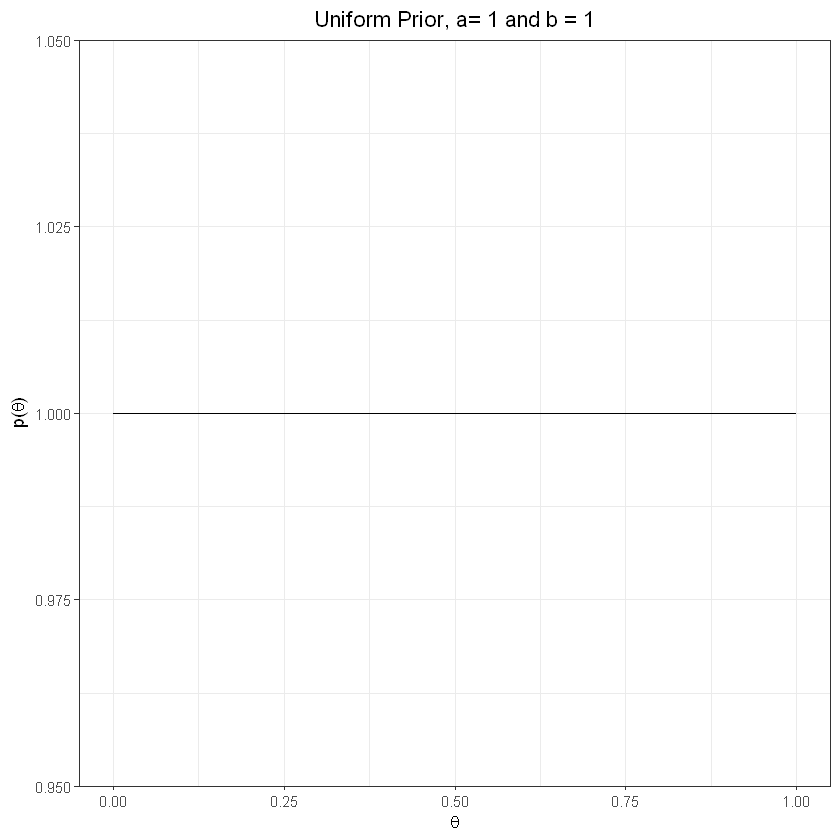

In [5]:
plot_prior(1,1) + labs(title="Uniform Prior, a= 1 and b = 1") + theme(plot.title = element_text(hjust = 0.5))

#### Weakly informative prior, bimodial

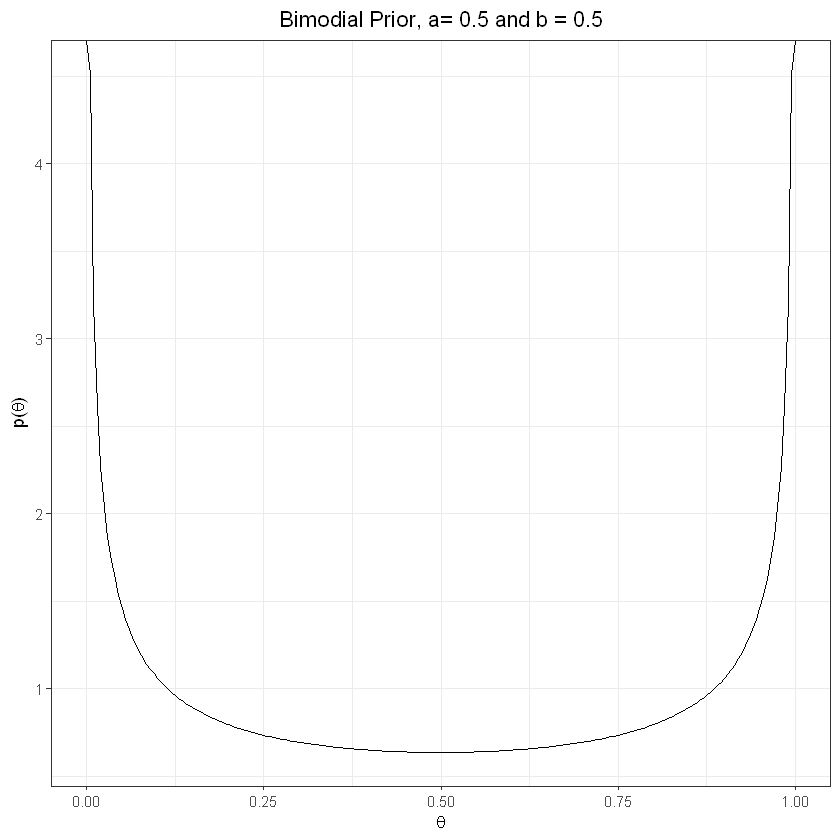

In [6]:
plot_prior(0.5,0.5) + labs(title="Bimodial Prior, a= 0.5 and b = 0.5") + theme(plot.title = element_text(hjust = 0.5))

#### Informative prior, "failure" more likely
The higher the number of observations, the greater the influence on the posterior

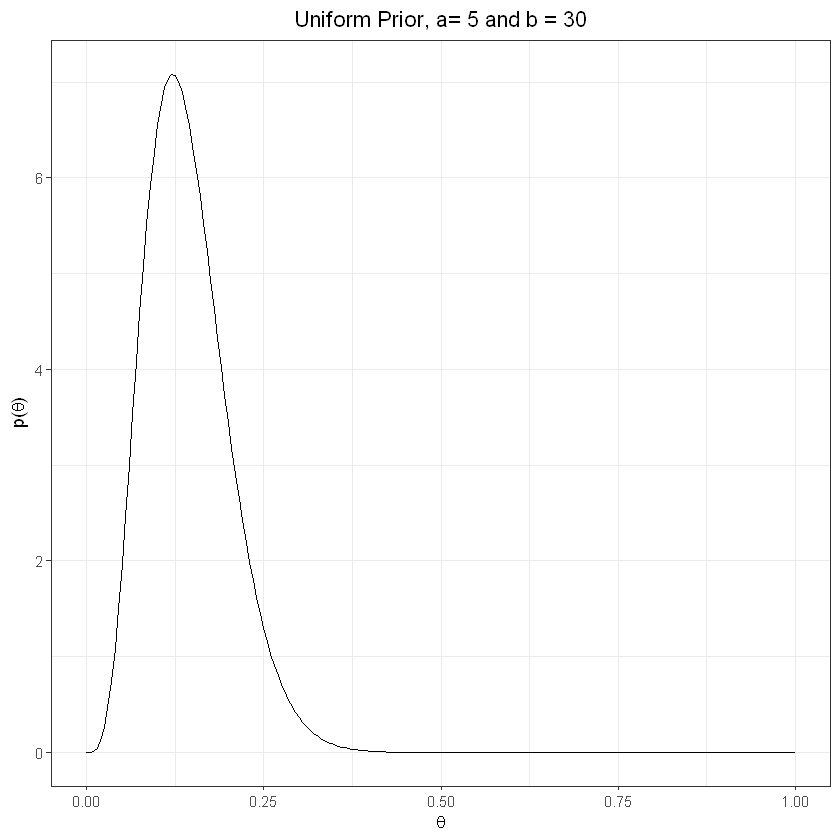

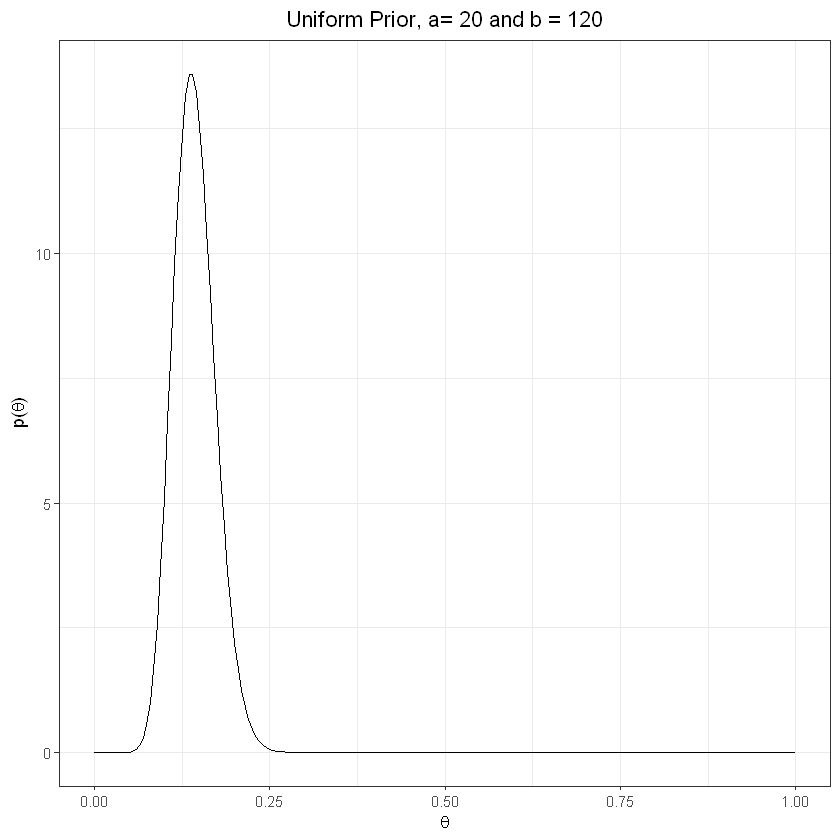

In [7]:
plot_prior(5,30) + labs(title="Uniform Prior, a= 5 and b = 30") + theme(plot.title = element_text(hjust = 0.5))
plot_prior(20,120) + labs(title="Uniform Prior, a= 20 and b = 120") + theme(plot.title = element_text(hjust = 0.5))

### Deriving posterior
Prior plot values. Re-express binomial as beta dist.

In [8]:
  prior_a = 50 #successes
  prior_b = 250 #failures
  prior_n = prior_a + prior_b #observations
  prior_theta = prior_a/prior_n
  prior <- data.frame('Dist'='Prior','x'=seq(0,1,0.005), 'y'=dbeta(seq(0,1,0.005),prior_a,prior_b))

Observations are taken from the earlier binomial sample.

In [9]:
  obs_a <- sample_success + 1
  obs_b <- sample_n - sample_success + 1
  observations <- data.frame('Dist'='Observations',x=seq(0,1,0.005), y=dbeta(seq(0,1,0.005),obs_a,obs_b))

In this example, the posterior is a simple combination of the prior and observations.

In [10]:
  post_a <- sample_success + prior_a - 1 #combination of prior and observed successes
  post_b <- sample_n - sample_success + prior_b - 1
  post_theta <- post_a / (post_a + post_b)
  posterior <- data.frame('Dist'='Posterior','x'=seq(0,1,0.005), 'y'=dbeta(seq(0,1,0.005),post_a,post_b))

This can be plotted as:

Warning message:
"Ignoring unknown parameters: label"


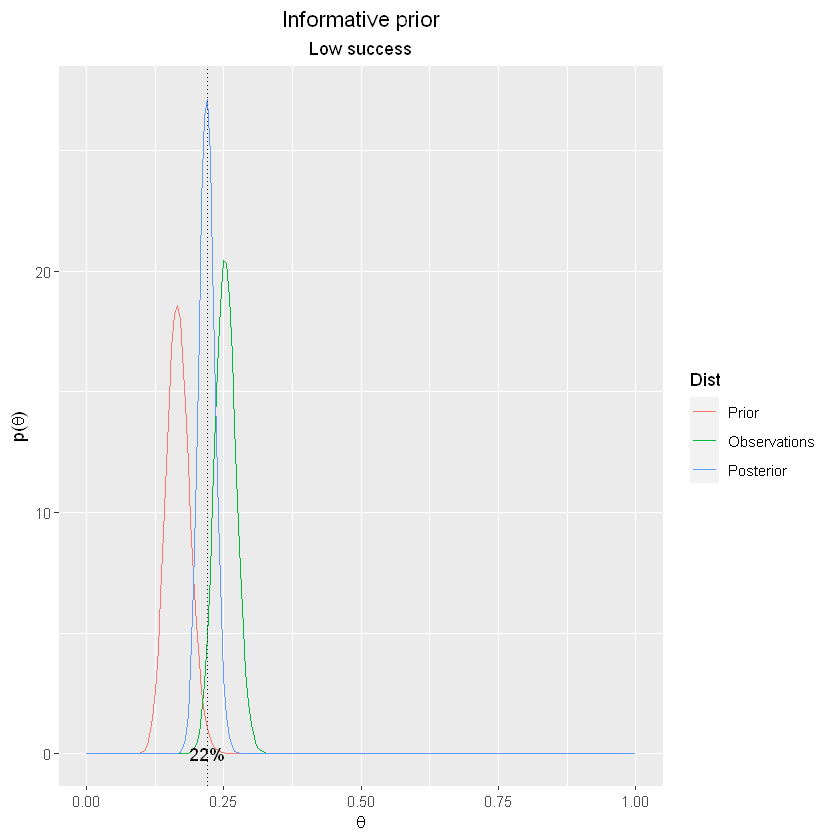

In [11]:
model_plot <- rbind(prior,observations,posterior)
with(model_plot, Dist <- factor(Dist, levels = c('Prior', 'Observations','Posterior'), ordered = TRUE))

qplot(model_plot$x, model_plot$y, geom='line',color = model_plot$Dist) +
ylab(expression(paste('p(',theta,')', sep = ''))) +
xlab(expression(theta)) +
geom_vline(xintercept = post_theta, linetype="dotted", color = "black", label="blah") +
scale_color_discrete(name = "Dist")  + 
annotate("text",x=post_theta, y=0, label=label_percent()(post_theta)) +
labs(title="Informative prior", subtitle="Low success") + 
theme(plot.title = element_text(hjust = 0.5)) +
theme(plot.subtitle = element_text(hjust = 0.5))

## Regression - logistic
### Background

RSTANARM is an interface in R for STAN where [Stan](https://mc-stan.org/) is a platform for Bayesian inference - it is a probabilistic programming framework where the guts of the inference method happens in the background, while the user focuses on parameterising the model in R. RJAGS is an interface in R for JAGS (Just Another Gibbs Sample) where [JAGS](https://mcmc-jags.sourceforge.io/) is similarly a platform for Bayesian modeling.

Models in both STAN and JAGS can make use of Markov chains Monte Carlo (MCMC) methods. MCMC methods provide a way to take random samples approximately from a posterior distribution. Such samples can be used to summarize any aspect of the posterior distribution of a statistical model.

RSTANARM and RJAGS have pre-written code for common models like regression. 

Under a Frequentest approach to linear regression, for a given set of response variables y, the relationship between y and a set of regressor variables x is assumed to be linear (informed by a set of parameters $\beta$), with an error term, i.e. $y = X\beta + \epsilon$.

The error term, $\epsilon$ is assumed to be normally distributed and the regression co-efficients are estimated by minimising the error term commonly using ordinary least squares (OLS). We make some other assumptions about the error term - not correlated with X and i.i.d.; and define $Var(\epsilon)=\sigma^2$. The generalised form allows the response variable to have an error that is not normal - this is achieved by allowing the linear model to be related to the response variable via a link function and by allowing the magnitude of the variance of each measurement to be a function of its predicted value.

With Bayesian inference we are interested in the posterior _distributions_ of the parameters $\beta$ and $\sigma$, rather than point estimates. We also want to influence those distributions with some prior knowledge of their behaviour:

$p(\beta,\sigma|y,X) \propto p(y|\beta,\sigma)p(\beta,\sigma)$ 

$p(\beta,\sigma|y,X)$ is not a normalised probability density function (i.e. is proportional to the likelihood and prior). However, we can sample from it and therefore estimate any quantity of interest e.g. mean or variance, [@Recipes, p825]. For this we use MCMC, @Recipes, p825:

>"MCMC is a random sampling method... the goal is to visit a point $x$ with a probability proportional to some given distribution function $\pi(x)$ [not necessarily a probability]. Why would we want to sample a distribution in this way? THe answer is that Bayesian methods, often implemented using MCMC, provide a powerful way of estimating the parameters of a model and their degree of uncertainty." 

### Heart disease data

The Framingham Heart Study is a longitudinal study of cardiovastular disease in a sample population within Framingham, Massachusetts. A subset of data for teaching is available at request from the [U.S. National Heart, Lung and Blood Institute](https://biolincc.nhlbi.nih.gov/teaching/). This dataset is not appropriate for publication and has been anonymised, but is nevertheless useful for illustrative purposes here. The dataset:

>"..is a subset of the data collected as part of the Framingham study and includes laboratory, clinic, questionnaire, and adjudicated event data on 4,434 participants. Participant clinic data was collected during three examination periods, approximately 6 years apart, from roughly 1956 to 1968. Each participant was followed for a total of 24 years for the outcome of the following events: Angina Pectoris, Myocardial Infarction, Atherothrombotic Infarction or Cerebral Hemorrhage (Stroke) or death."

We'll look at a logistic regression model example using predefined Bayesian models in RSTANARM.

In [12]:
df_heart <- read.csv(file = '../_static/bayesian_applications/frmgham2.csv') 
df_heart <- df_heart[c(1:23)] %>% filter(PERIOD==2) # ignoring health event data, only looking at observations at period == 2 (observations for participants are not independent over time; this does have limitations e.g. observations are truncated at death which could be due to heart disease)
ignore_cols <- names(df_heart) %in% c("PERIOD","RANDID","TIME", "PREVMI", "PREVAP") #exclude identifier and time columns; exclude  PREVMI and PREVAP as they are a subset of PREVCHD
df_heart <- df_heart[!ignore_cols]
head(df_heart)

SEX,TOTCHOL,AGE,SYSBP,DIABP,CURSMOKE,CIGPDAY,BMI,DIABETES,BPMEDS,HEARTRTE,GLUCOSE,educ,PREVCHD,PREVSTRK,PREVHYP,HDLC,LDLC
2,260,52,105,69.5,0,0,29.43,0,0,80,86,2,0,0,0,NA,NA
1,283,54,141,89.0,1,30,25.34,0,0,75,87,1,0,0,0,NA,NA
2,232,67,183,109.0,1,20,30.18,0,0,60,89,3,0,0,1,NA,NA
2,343,51,109,77.0,1,30,23.48,0,0,90,72,3,0,0,0,NA,NA
2,230,49,177,102.0,0,0,31.36,0,1,120,86,2,0,0,1,NA,NA
2,220,70,149,81.0,0,0,36.76,0,0,80,98,1,1,0,1,NA,NA


[Data description]('../_static/Framingham Longitudinal Data Documentation.pdf') highlights:

* RANDIND: unique identifier.
* SEX: 1=male; 2=female (categorical, 1/2).
* TIME: number of days since baseline exam (continuous).
* PERIOD: examination cycle (categorical, 1,2 or 3). We'll focus on period 2 - observations for the same participant are not independent over time.
* TOTCHOL: total cholesterol level (continuous).
* AGE: Age of the patient rounded to nearest year (continuous).
* SYSBP: systolic blood pressure (continuous).
* DIABP: diastolic blood pressure (continuous).
* CURSMOKE: whether or not the patient is a current smoker (categorical, 0/1).
* CIGPDAY: the number of cigarettes smoked per day on average (continuous).
* BMI: Body Mass Index (continuous).
* DIABETES: whether or not the patient had diabetes (categorical, 0/1).
* BPMEDS: whether or not the patient was on blood pressure medication (categorical, 0/1).
* HEARTRTE: heart rate (continuous).
* GLUCOSE: glucose level (continuous).
* EDU: attained Education (categorical, 1=0-11 year; 2=High School Diploma, GED; 3=Some College, Vocational School; 4=College (BS, BA) degree or more).
* HDLC: High Density Lipoprotein Cholesterol - only available for period 3 (continuous).
* LDLC: Low Density Lipoprotein Cholesterol - only available for period 3 (continuous).
* PREVCHD: prevalence of Coronary Heart Disease (categorical, 0/1).
* PREVAP: prevalence of Angina Pectoris (categorical, 0/1). Excluded from model as it is a subset of PREVCHD.
* PREVMI: Prevalence of Myocardial Infarction (categorical, 0/1). Excluded from model as it is a subset of PREVCHD.
* PREVSTRK: whether or not the patient had previously had a stroke (categorical, 0/1).
* PREVHYP: whether or not the patient was hypertensive (categorical, 0/1).

Using the [DataExplore package](https://cran.r-project.org/web/packages/DataExplorer/vignettes/dataexplorer-intro.html), we can see that the data is mostly complete apart from missing entries in 'glucose' and to a lesser extent 'education'.

rows,columns,discrete_columns,continuous_columns,all_missing_columns,total_missing_values,complete_rows,total_observations,memory_usage
3930,18,0,16,2,8720,0,70740,334464


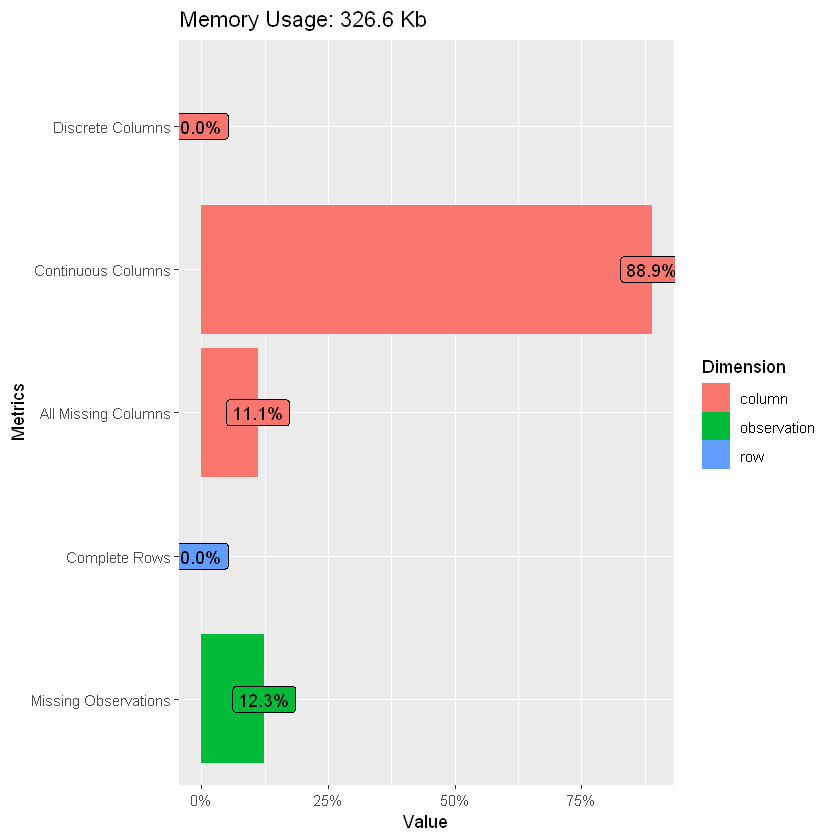

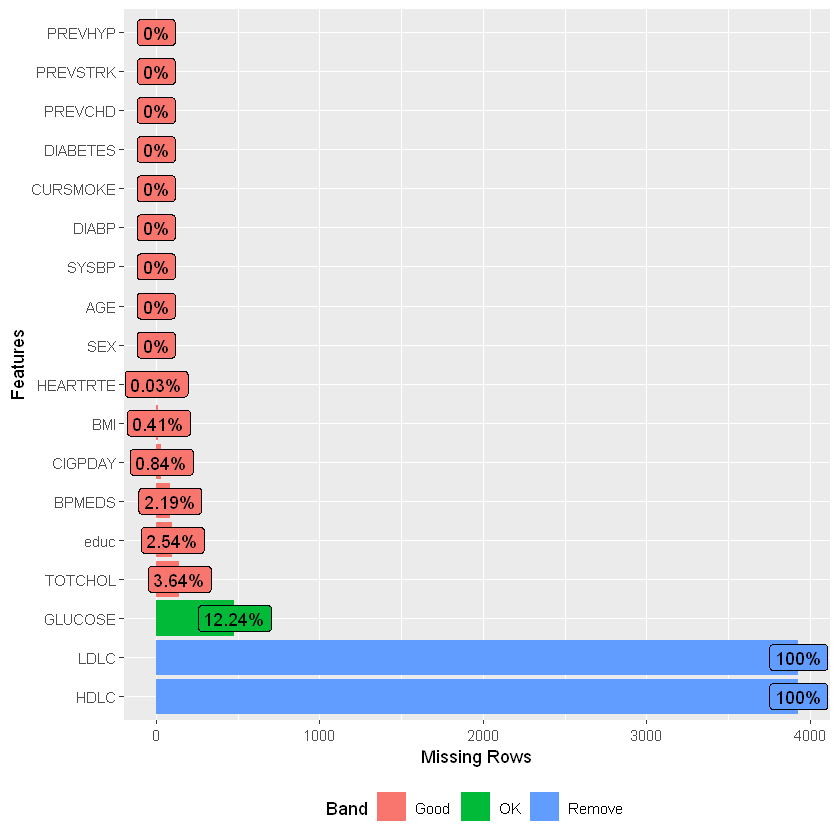

In [13]:
introduce(df_heart)
plot_intro(df_heart)
plot_missing(df_heart)

Given around 12% of glucose records are missing as well as all of HDL and LDL (only available for period 3), drop the columns. Also drop rows with other missing data as these are small in number.

In [14]:
df_heart$GLUCOSE <- NULL
df_heart$HDLC <- NULL
df_heart$LDLC <- NULL
df_heart <- na.omit(df_heart)

Plots of the data:

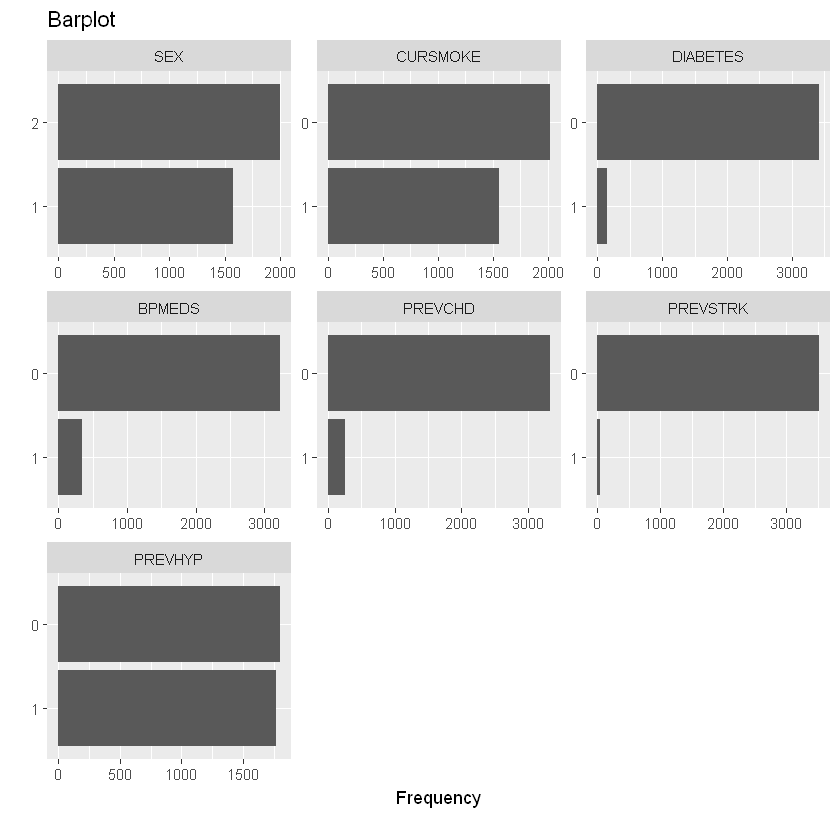

In [15]:
plot_bar(df_heart, title="Barplot")

Of the 3.6k remaining records, ~7% have a flag for heart disease:

In [16]:
table(df_heart$PREVCHD)


   0    1 
3319  253 

Further plots and checking distributions:

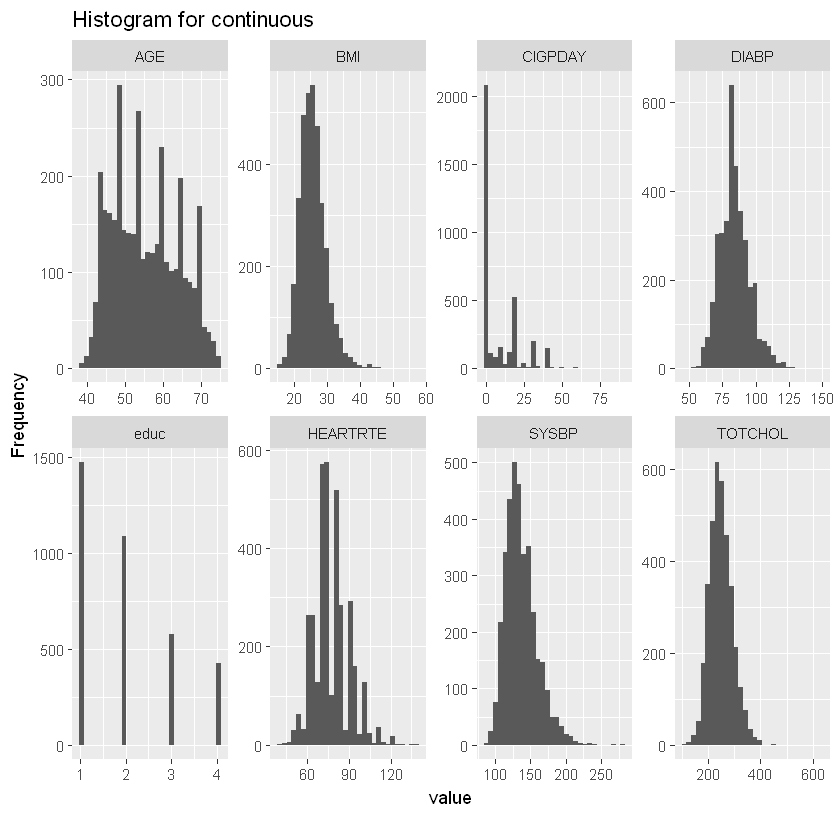

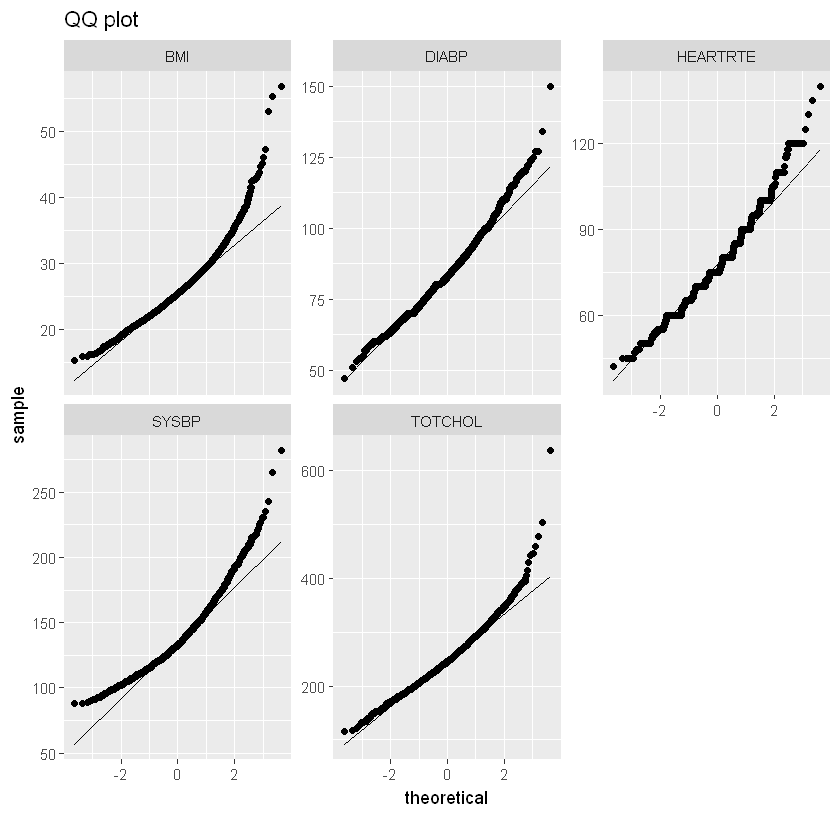

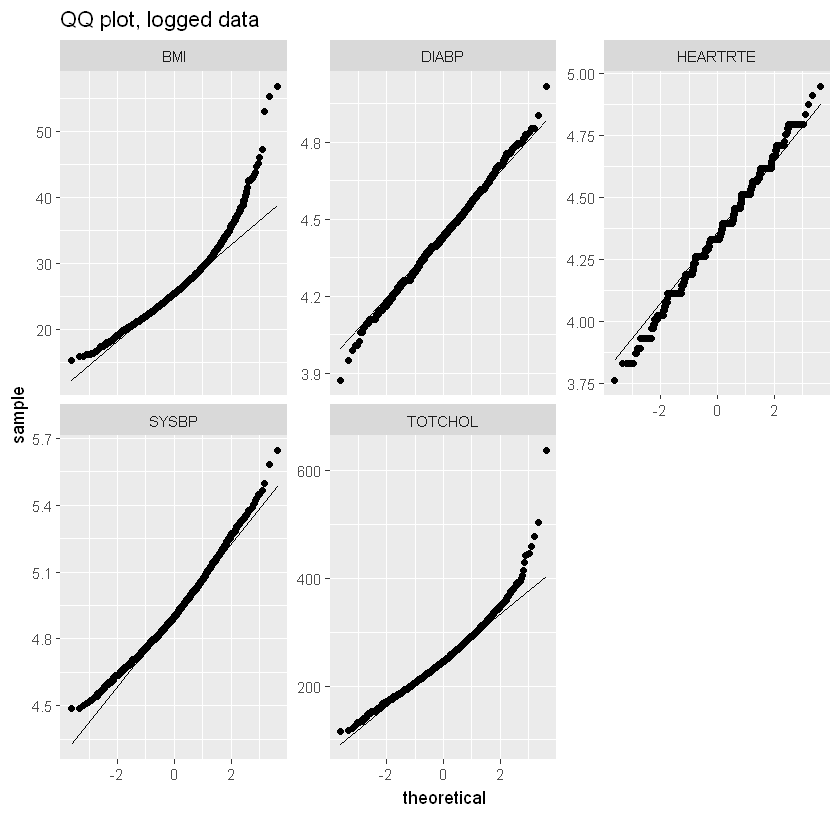

In [17]:
plot_histogram(df_heart, title="Histogram for continuous")

qq_data <- df_heart[,c("BMI", "DIABP", "HEARTRTE", "SYSBP", "TOTCHOL")]
plot_qq(qq_data, title="QQ plot")
log_qq_data <- update_columns(qq_data, 2:4, function(x) log(x + 1))
plot_qq(log_qq_data, title="QQ plot, logged data")

Most significantly correlated with heart disease are AGE, SYSBP, DIABETES, BPMEDS and PREVHYP.

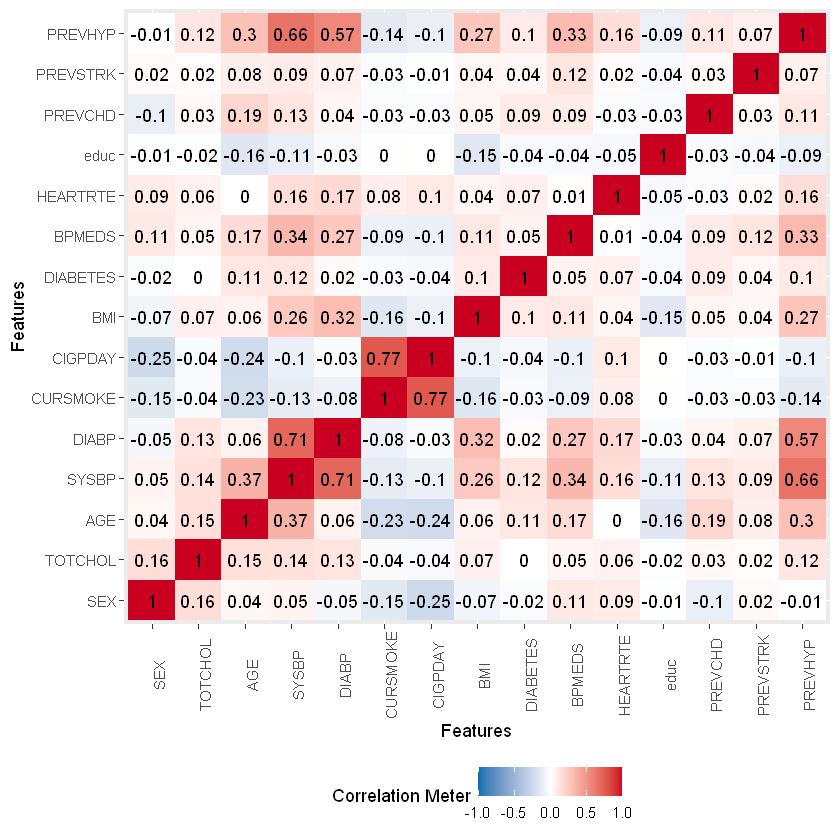

In [18]:
plot_correlation(na.omit(df_heart))

Split data into training and testing data sets.

In [19]:
# Create a random sample of row IDs
sample_rows <- sample(nrow(df_heart),0.75*nrow(df_heart))
# Create the training dataset
df_heart_train <- df_heart[sample_rows,]
# Create the test dataset
df_heart_test <- df_heart[-sample_rows,]

Fit a simple GLM using all data:

In [20]:
full_model_glm <- glm(PREVCHD~.,data=df_heart_train, family = "binomial")
summary(full_model_glm)


Call:
glm(formula = PREVCHD ~ ., family = "binomial", data = df_heart_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1371  -0.4105  -0.2756  -0.1783   2.8715  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -7.327533   1.272399  -5.759 8.47e-09 ***
SEX         -1.174290   0.181350  -6.475 9.46e-11 ***
TOTCHOL      0.003505   0.001743   2.011   0.0443 *  
AGE          0.079417   0.011571   6.864 6.71e-12 ***
SYSBP        0.010771   0.005027   2.143   0.0321 *  
DIABP       -0.006257   0.009562  -0.654   0.5129    
CURSMOKE    -0.066890   0.267342  -0.250   0.8024    
CIGPDAY      0.003823   0.010371   0.369   0.7124    
BMI          0.010779   0.020879   0.516   0.6057    
DIABETES     0.689420   0.274347   2.513   0.0120 *  
BPMEDS       0.450246   0.232713   1.935   0.0530 .  
HEARTRTE    -0.006751   0.006442  -1.048   0.2946    
educ        -0.033519   0.077981  -0.430   0.6673    
PREVSTRK     0.462778   0.498220   0.

Use stepwise regression to reduce the explanatory variables:

In [21]:
# specify a null model with no predictors
null_model_glm <- glm(PREVCHD ~ 1, data = df_heart_train, family = "binomial")
# use a forward stepwise algorithm to build a parsimonious model
step_model_glm <- step(null_model_glm, scope = list(lower = null_model_glm, upper = full_model_glm), direction = "forward")

Start:  AIC=1353.07
PREVCHD ~ 1

           Df Deviance    AIC
+ AGE       1   1251.2 1255.2
+ SYSBP     1   1307.3 1311.3
+ PREVHYP   1   1318.4 1322.4
+ SEX       1   1321.2 1325.2
+ BPMEDS    1   1333.8 1337.8
+ DIABETES  1   1334.6 1338.6
+ DIABP     1   1344.5 1348.5
+ PREVSTRK  1   1346.6 1350.6
+ BMI       1   1347.6 1351.6
+ educ      1   1347.6 1351.6
+ TOTCHOL   1   1348.0 1352.0
+ CURSMOKE  1   1348.1 1352.1
<none>          1351.1 1353.1
+ CIGPDAY   1   1349.4 1353.4
+ HEARTRTE  1   1350.1 1354.1

Step:  AIC=1255.2
PREVCHD ~ AGE

           Df Deviance    AIC
+ SEX       1   1214.2 1220.2
+ SYSBP     1   1239.9 1245.9
+ PREVHYP   1   1242.2 1248.2
+ DIABETES  1   1242.4 1248.4
+ BPMEDS    1   1244.0 1250.0
+ DIABP     1   1244.9 1250.9
+ BMI       1   1249.0 1255.0
<none>          1251.2 1255.2
+ PREVSTRK  1   1249.3 1255.3
+ CIGPDAY   1   1249.6 1255.6
+ HEARTRTE  1   1250.4 1256.4
+ CURSMOKE  1   1250.8 1256.8
+ TOTCHOL   1   1250.9 1256.9
+ educ      1   1251.0 1257.0

St

Summary of the model:

In [22]:
summary(step_model_glm)


Call:
glm(formula = PREVCHD ~ AGE + SEX + SYSBP + DIABETES + BPMEDS + 
    TOTCHOL, family = "binomial", data = df_heart_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1663  -0.4092  -0.2767  -0.1804   2.8492  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -8.217242   0.799672 -10.276  < 2e-16 ***
AGE          0.083181   0.010413   7.988 1.37e-15 ***
SEX         -1.174758   0.174141  -6.746 1.52e-11 ***
SYSBP        0.010782   0.003580   3.011  0.00260 ** 
DIABETES     0.702185   0.270141   2.599  0.00934 ** 
BPMEDS       0.501126   0.228104   2.197  0.02803 *  
TOTCHOL      0.003399   0.001744   1.949  0.05128 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1351.1  on 2678  degrees of freedom
Residual deviance: 1181.6  on 2672  degrees of freedom
AIC: 1195.6

Number of Fisher Scoring iterations: 6


Dropping BPMEDS, HEARTRTE and BMI as little impact on AIC:

In [23]:
final_model_glm <- glm(PREVCHD ~ AGE + SEX + PREVHYP + DIABETES + TOTCHOL, family = "binomial",data = df_heart_train)
summary(final_model_glm)


Call:
glm(formula = PREVCHD ~ AGE + SEX + PREVHYP + DIABETES + TOTCHOL, 
    family = "binomial", data = df_heart_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1822  -0.4204  -0.2799  -0.1844   2.9405  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -7.411998   0.735501 -10.077  < 2e-16 ***
AGE          0.087543   0.010203   8.580  < 2e-16 ***
SEX         -1.092521   0.170406  -6.411 1.44e-10 ***
PREVHYP      0.528985   0.173512   3.049  0.00230 ** 
DIABETES     0.769936   0.267135   2.882  0.00395 ** 
TOTCHOL      0.003768   0.001728   2.180  0.02922 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1351.1  on 2678  degrees of freedom
Residual deviance: 1191.0  on 2673  degrees of freedom
AIC: 1203

Number of Fisher Scoring iterations: 6


Fit a Bayes glm using the same explanatory variables. Here parameter estimates no longer have test statistics and p-values as in the frequentist regression. This is because Bayesian estimation samples from the posterior distribution. This means that instead of a point estimate and a test statistic, we get a distribution of plausible values for the parameters, and the estimates section of the summary summarizes those distributions.

Further documentation on Bayesian generalised linear models via Stan [is here](https://mc-stan.org/rstanarm/reference/stan_glm.html). Documentation on choice of priors [is here](http://mc-stan.org/rstanarm/articles/priors.html). If priors are not specified, default weekly informative priors are used - you can call a summary of the modeled priors (see below). Default priors are autoscaled to make them less informative (see below for notes on scaling).

In [24]:
not_run_sample_only <- function(){model_bayes_glm_heart <- stan_glm(PREVCHD ~ AGE + SEX + PREVHYP + DIABETES + TOTCHOL, family = "binomial",data=df_heart_train, iter=2000, warmup=500)}
# chains is number of sample paths from posterior; iter is number of samples within a chain; warmup is number of iterations to discard

A summary of the model below. "Sigma" is the standard deviation of the errors; "mean_PPD" is the mean of the posterior predictive samples.MCMC diagnostics - "RHat" is a measure of within chain variance compared to across chain variance (<1.1 implies convergence); "log-posterior" is similar to likelihood.

In [25]:
not_run_sample_only <- function(){print(summary(model_bayes_glm),digits=4)}

The stan model used default normal priors for intercepts and coefficients. Default priors are automatically scaled to limit how informative they are - below we can see the adjusted (scaled) prior for the coefficients differs from the default 2.5:

In [26]:
# summary of priors
not_run_sample_only <- function(){print(prior_summary(model_bayes_glm),digits=4)}

Credible intervals express the probability that a parameter falls within a given range (vs a confidence interval which is the probability that a range contains the true value of the parameter). These credible intervals are computed by finding the relevant quantiles of the draws from the posterior distribution. They produce similar ranges to the confidence intervals from the frequentist approach.

In [27]:
confint(final_model_glm, level=0.95)
not_run_sample_only <- function(){posterior_interval(model_bayes_glm, prob=0.95)}

Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),-8.8776915163,-5.991585083
AGE,0.0678137734,0.107852699
SEX,-1.4311597984,-0.762253800
PREVHYP,0.1934226155,0.874803105
DIABETES,0.2242889992,1.275840724
TOTCHOL,0.0003353271,0.007113462


### Adjusting scales and changing priors

stan_glm allows a selection of prior distributions for the coefficients, intercept, and auxiliary parameters. The prior distributions can be altered by specifying different locations/scales/dfs, but all the prior take the form of a single chosen probability distribution. 

Some drivers for wanting to specify a prior:
* Available information/ research might suggest a base value for our parameters. Particularly valuable if our own observed data is sparse.
* We may not have a good idea of the value, but know that it is constrained in some way e.g. is positive.

The scale is the standard deviation of the prior. As noted earlier, the model autoscales to ensure priors are not too informative. We can turn this off when we specify our own priors. Documentation on choice of priors [is here](http://mc-stan.org/rstanarm/articles/priors.html).

To allow for varying distributions across the priors, we need to define the model in STAN or JAGS. See the linear regression example below for an example of this in JAGS.

Specifying our own priors below. Little impact on the posterior estimates.

In [28]:
not_run_sample_only <- function(){model_bayes_glm_scale <- stan_glm(PREVCHD ~ AGE + SEX + PREVHYP + DIABETES + TOTCHOL, family = "binomial",data=df_heart_train, iter=2000, warmup=500,
                            prior_intercept = normal(location = 0, scale = 10, autoscale = FALSE),
                            prior = normal(location = 0, scale = 5, autoscale = FALSE),
                            prior_aux = exponential(rate = 1, autoscale = FALSE)
                            )
print(summary(model_bayes_glm_scale),digits=4)}

### Model fit

We are able to extract predictions from each iteration of the posterior sampling. We can extract predictions for new data. Could be tested against the observations for goodness of fit. The follwing from the manual, @rstanarm, p43:

>"The posterior predictive distribution (posterior_predict) is the distribution of the outcome implied by the model after using the observed data to update our beliefs about the unknown parameters in the model. Simulating data from the posterior predictive distribution using the observed predictors is useful for checking the fit of the model. Drawing from the posterior predictive distribution at interesting values of the predictors also lets us visualize how a manipulation of a predictor affects (a function of)the outcome(s). With new observations of predictor variables we can use the posterior predictive distribution to generate predicted outcomes." 

In [29]:
not_run_sample_only <- function(){posteriors <- posterior_predict(model_bayes_glm,newdata=df_heart_test)
posterior <- as.data.frame(posteriors) # each column is a data point from the dataset and each row is a prediction
# Print 10 predictions for 5 lives
print("10 predictions for 5 lives")
posteriors[1:10, 1:5]}

We can plot the posterior distributions for the model parameters from the samples:

In [30]:
not_run_sample_only <- function(){posterior <- as.matrix(model_bayes_glm)

plot1<- mcmc_areas(posterior, pars = c("AGE"), prob = 0.80)
plot2<- mcmc_areas(posterior, pars = c("SEX"), prob = 0.80)
plot3<- mcmc_areas(posterior, pars = c("PREVHYP"), prob = 0.80)
plot4<- mcmc_areas(posterior, pars = c("DIABETES"), prob = 0.80)
plot5<- mcmc_areas(posterior, pars = c("TOTCHOL"), prob = 0.80)

grid.arrange(plot1,plot2, plot3, plot4, plot5, top="Posterior distributions (median + 80% intervals)")}

We can extract the $R^2$ from the posterior distribution and plot:

In [31]:
not_run_sample_only <- function(){r2_posterior <- bayes_R2(model_bayes_glm)
summary(r2_posterior)
hist(r2_posterior)} #expect normal

Posterior predictive checks can be extracted using "pp_check"

* "dens_overlay" - each light blue line represents the distribution of predicted scores from a single replication, and the dark blue line represents the observed data. If the model fits, the dark blue line should align closely with the light blue lines.
* "stat" in the "pp_check" function, we can get a distribution of the mean of the dependent variable from all replications. These are the light blue bars: the means from each replication plotted as a histogram. The mean from the observed data is then plotted on top as a dark blue bar. 

Here the outcome is binary so the density overlay outcomes are concentrated at one or zero.

In [32]:
not_run_sample_only <- function(){pp_check(model_bayes_glm, "stat")
pp_check(model_bayes_glm, "dens_overlay")}

Further considerations: The [loo package](https://mc-stan.org/users/interfaces/loo) provides "efficient approximate leave-one-out cross-validation (LOO), approximate standard errors for estimated predictive errors (including comparisons), and the widely applicable information criterion (WAIC).The loo package can be used to estimate predictive error of any MCMC item-level log likelihood output".

## Regression - linear

The above example looked at a binary response. In this example we'll look at predicting a continuous variable using data on my household electricity consumption over 2016-2021. The above example used stan_glm in RSTANARM. Here we will use a model defined in RJAGS with additional flexibility around the choice of priors, which is also possible in a paramaterised model for STAN. RJAGS combines the power of R with the "Just Another Gibbs Sampler" or "JAGS" engine. To get started, first download the "JAGS" program, then set up the packages as above.

Both JAGS and STAN allow for the parameterisation of a range of different models. The example below was chosen for comparison with a conventional GLM approach.

Data prep:

* Daily electricity usage for a household in Sydney over 2019-21. Rows represent half hourly readings/ estimates.
* Data are grouped into daily usage.
* Also includes are temperatures, sunlight and rainfall data for the area taken from BOM.
* Calculated fields for weekdays vs weekends, seasons and a post-covid working from home indicator.


In [33]:
df_usage <- read.csv(file = '../_static/bayesian_applications/elec_usage.csv')
df_usage <- df_usage %>% mutate(Date = as.Date(Date, format="%Y-%m-%d"), EndDate = parse_date_time(EndDate, '%Y-%m-%d %H:%M:%S'), StartDate = parse_date_time(StartDate, '%Y-%m-%d %H:%M:%S'))
df_usage <- df_usage[c(-2,-3,-4,-6)] %>% # drop start and end dates, rate type, duration
group_by(Date) %>% summarise(Usage = sum(Usage), MaxTemp = max(MaxTemp), MinTemp = min(MinTemp), Rain_mm = max(Rain_mm), Solar_Exposure = max(Solar_Exposure)) %>%
# Add in fields to identify seasons, weekend/ weekday and an indicator for the post-covid/ work from home period
mutate(Season=
  if_else(month(Date)>= 3 & month(Date) < 6,"Autumn", 
  if_else(month(Date)>= 6 & month(Date) < 9,"Winter", 
  if_else(month(Date)>= 9 & month(Date) < 12,"Spring","Summer"))),
Covid_Ind=if_else(Date>= "2020-03-15",1,0),
Weekend=
  if_else(wday(Date)==7 | wday(Date)==1,1,0))

df_usage$Season <- factor(df_usage$Season, levels = c("Summer","Autumn","Winter","Spring")) # change season levels

head(df_usage)

Date,Usage,MaxTemp,MinTemp,Rain_mm,Solar_Exposure,Season,Covid_Ind,Weekend
2019-12-21,21.064,26.7,21.0,0.0,27.1,Summer,0,1
2019-12-22,9.529,19.9,18.6,0.0,11.9,Summer,0,1
2019-12-23,15.739,22.1,17.2,0.0,14.4,Summer,0,0
2019-12-24,18.652,24.0,18.6,1.8,18.3,Summer,0,0
2019-12-25,18.924,23.2,21.6,0.2,27.8,Summer,0,0
2019-12-26,14.584,23.6,21.4,0.0,30.8,Summer,0,0


Data is mostly complete:

rows,columns,discrete_columns,continuous_columns,all_missing_columns,total_missing_values,complete_rows,total_observations,memory_usage
732,9,2,7,0,23,709,6588,53464


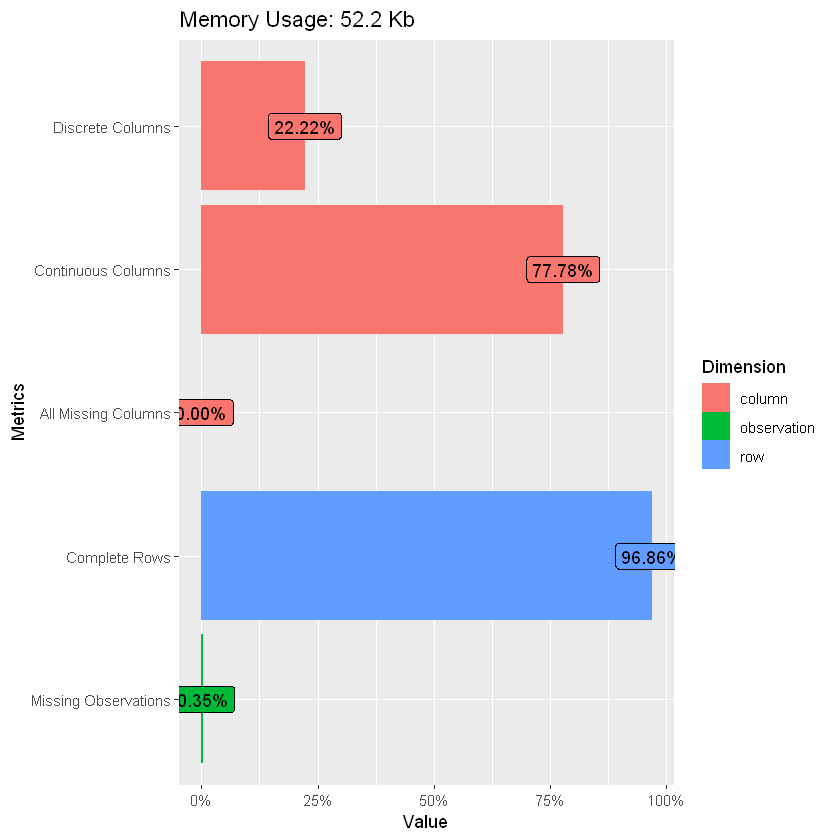

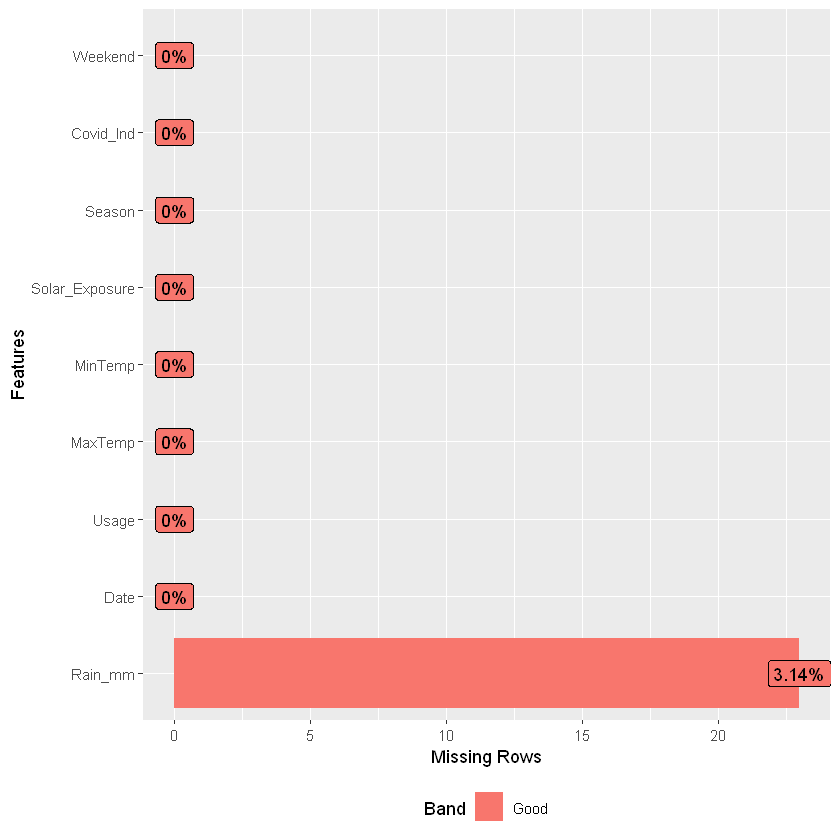

In [34]:
introduce(df_usage)
plot_intro(df_usage)
plot_missing(df_usage)

Drop records with NAs as they are few, also only include non-zero usage, review explanatory variables; Gamma dist potentially a better fit than normal for Usage given the skewness in the tail; alternatively use normal with a log link.

1 columns ignored with more than 50 categories.
Date: 707 categories




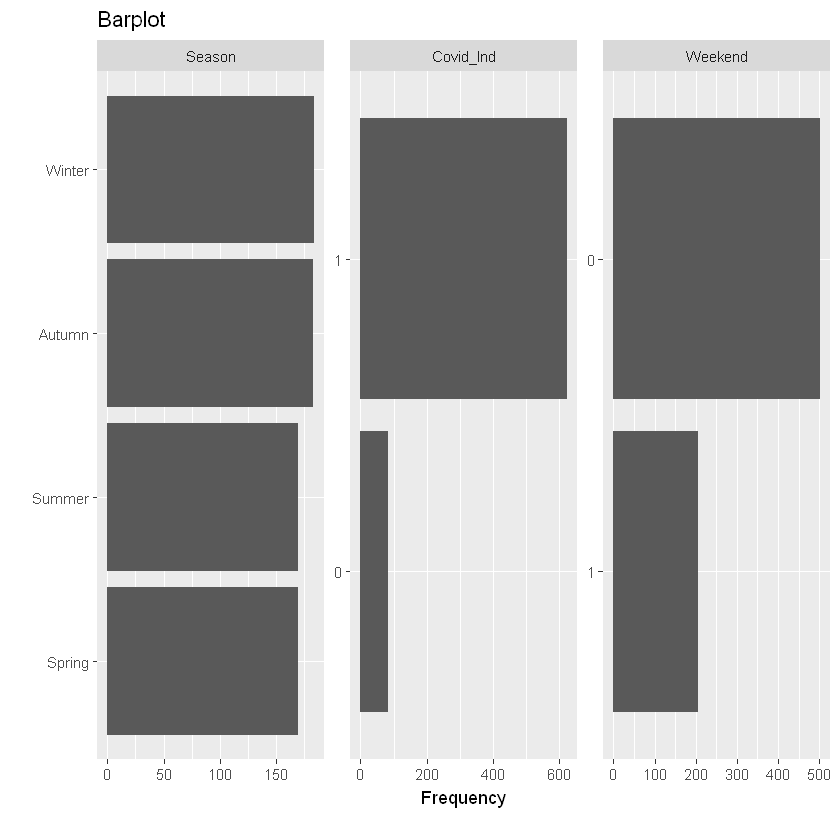

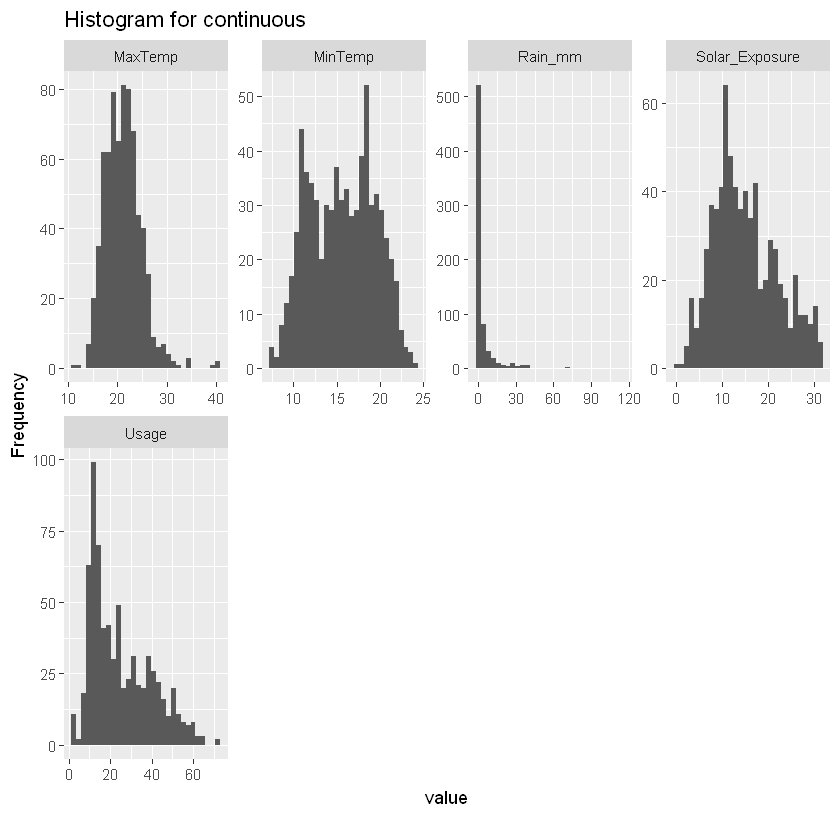

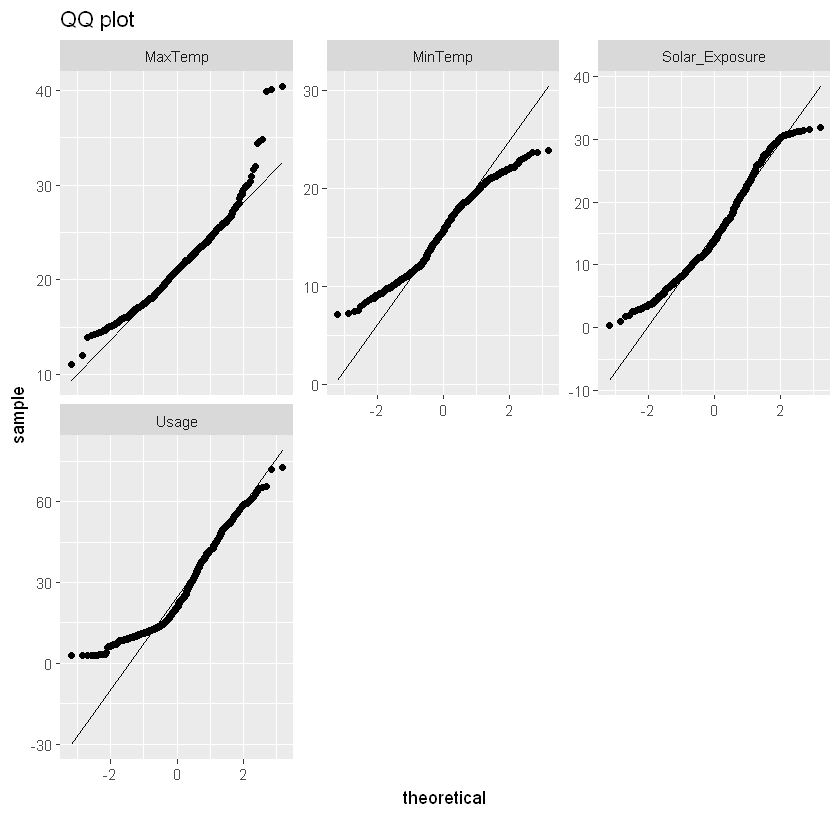

Fitting of the distribution ' gamma ' by matching moments 
Parameters : 
       estimate
shape 2.9114935
rate  0.1164095
Loglikelihood:  -2813.89   AIC:  5631.78   BIC:  5640.902 

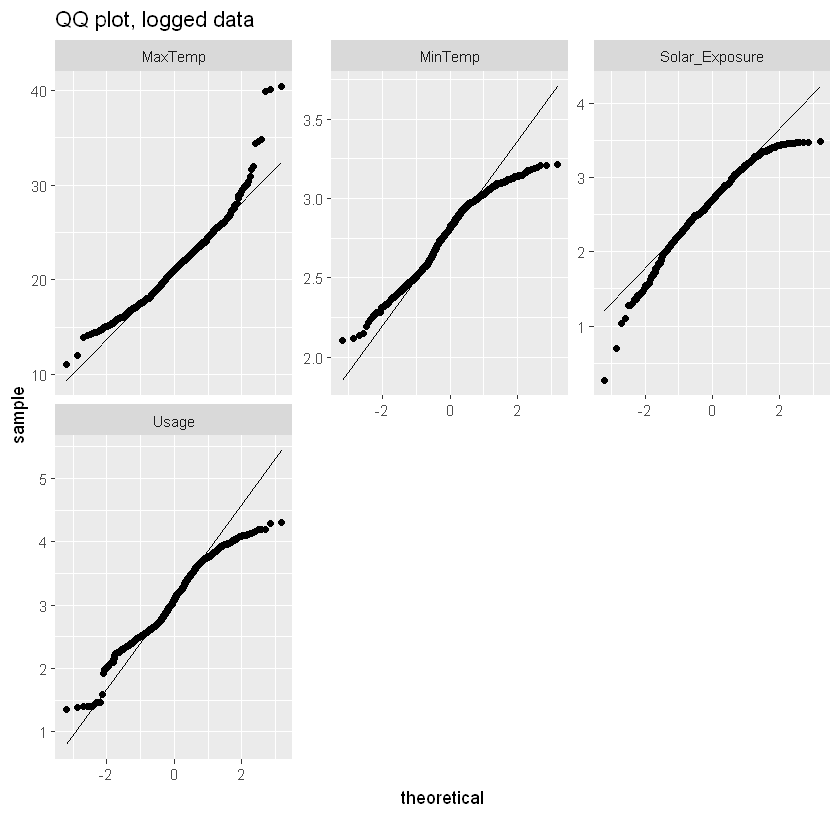

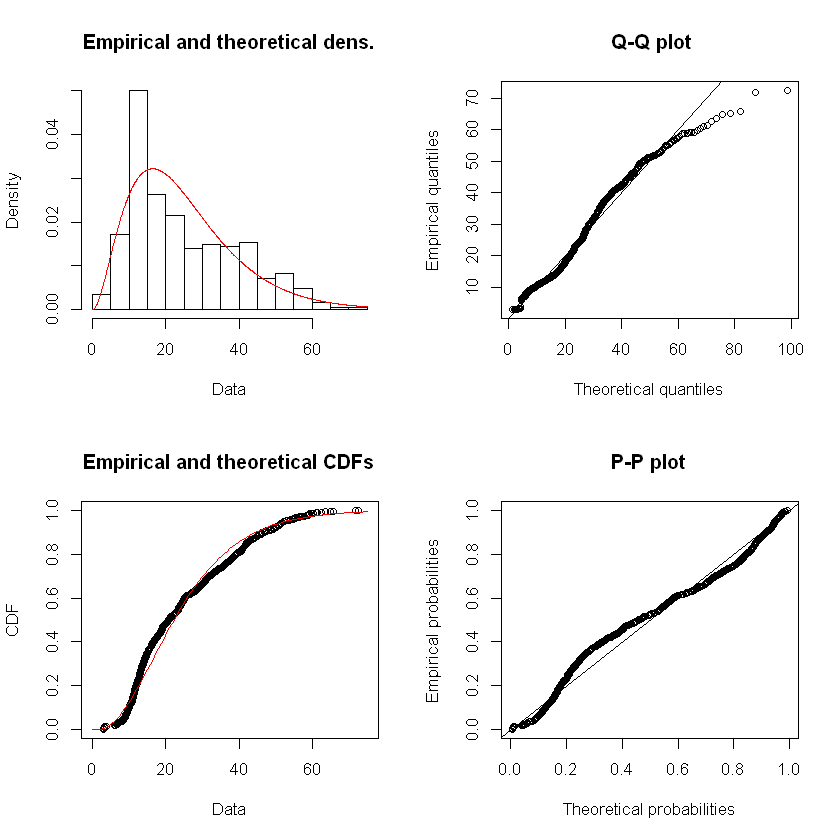

In [35]:
df_usage <- na.omit(df_usage)
df_usage <- df_usage %>% filter(Usage>0)

plot_bar(df_usage, title="Barplot")
plot_histogram(df_usage, title="Histogram for continuous")

qq_data <- df_usage[,c("MaxTemp", "MinTemp", "Solar_Exposure", "Usage")]
plot_qq(qq_data, title="QQ plot")
log_qq_data <- update_columns(qq_data, 2:4, function(x) log(x + 1))
plot_qq(log_qq_data, title="QQ plot, logged data")

usage_fit_gamma <- fitdist(df_usage$Usage, distr = "gamma", method = "mme")
summary(usage_fit_gamma)
plot(usage_fit_gamma)

Usage correlated with season, max/min temp and covid wfh indicator. Max and Min Temps are not surprisingly highly correlated with one another, with the seasons and with solar exposure.

1 features with more than 20 categories ignored!
Date: 707 categories




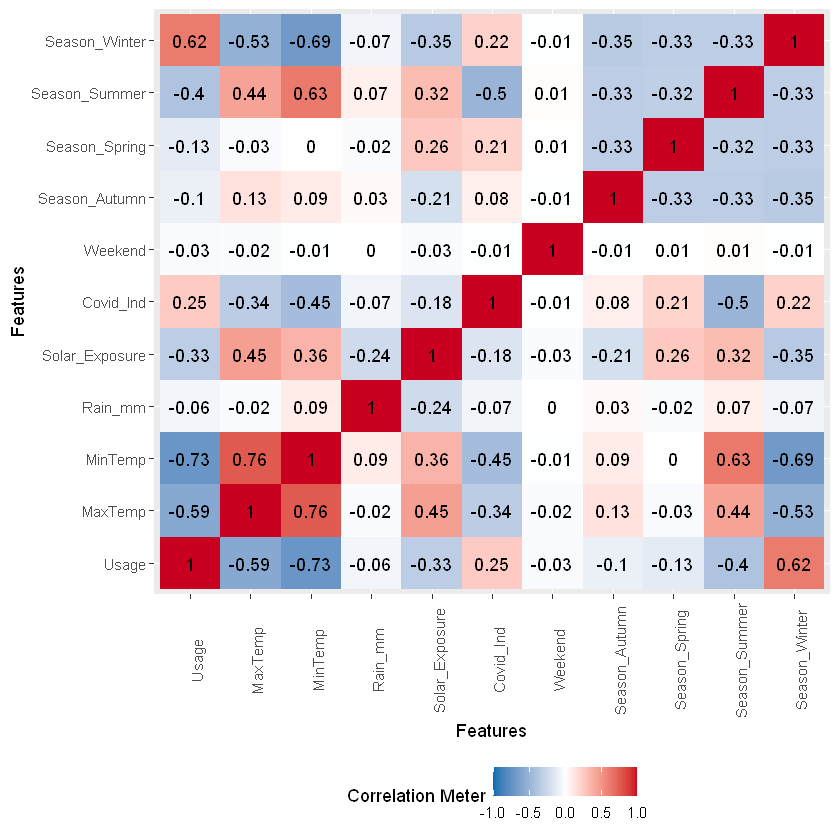

In [36]:
plot_correlation(na.omit(df_usage))

Split data into training and testing data sets:

In [37]:
# Create a random sample of row IDs
sample_rows <- sample(nrow(df_usage),0.75*nrow(df_usage))
# Create the training dataset
df_usage_train <- df_usage[sample_rows,]
# Create the test dataset
df_usage_test <- df_usage[-sample_rows,]

Fit a simple GLM using all variables:

In [38]:
full_model_glm <- glm(Usage~.,data=df_usage_train[-1], gaussian(link="log"))
summary(full_model_glm)


Call:
glm(formula = Usage ~ ., family = gaussian(link = "log"), data = df_usage_train[-1])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-49.745   -4.158   -0.242    3.739   50.272  

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     5.460269   0.192108  28.423  < 2e-16 ***
MaxTemp        -0.032919   0.008225  -4.002 7.19e-05 ***
MinTemp        -0.094049   0.009027 -10.418  < 2e-16 ***
Rain_mm        -0.001062   0.001673  -0.635   0.5258    
Solar_Exposure -0.016682   0.003693  -4.517 7.75e-06 ***
SeasonAutumn    0.072891   0.083503   0.873   0.3831    
SeasonWinter    0.053555   0.092984   0.576   0.5649    
SeasonSpring    0.057520   0.083743   0.687   0.4925    
Covid_Ind       0.018224   0.104769   0.174   0.8620    
Weekend        -0.072596   0.031904  -2.275   0.0233 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for gaussian family taken to be 82.98741)

    Null deviance: 

Use stepwise regression to reduce the explanatory variables:

In [39]:
# specify a null model with no predictors
null_model_glm <- glm(Usage ~ 1, data = df_usage_train, gaussian(link="log"))
# use a forward stepwise algorithm to build a parsimonious model
step_model_glm <- step(null_model_glm, scope = list(lower = null_model_glm, upper = full_model_glm), direction = "forward")

Start:  AIC=4377.32
Usage ~ 1

                 Df Deviance    AIC
+ MinTemp         1    48804 3907.1
+ MaxTemp         1    60308 4019.3
+ Season          3    68767 4092.8
+ Solar_Exposure  1   108574 4330.9
+ Covid_Ind       1   110962 4342.4
+ Rain_mm         1   117177 4371.3
<none>                118960 4377.3
+ Weekend         1   118939 4379.2

Step:  AIC=3907.1
Usage ~ MinTemp

                 Df Deviance    AIC
+ Solar_Exposure  1    44976 3865.8
+ MaxTemp         1    46103 3878.9
+ Weekend         1    48432 3905.1
<none>                 48804 3907.1
+ Season          3    48267 3907.2
+ Rain_mm         1    48684 3907.8
+ Covid_Ind       1    48804 3909.1

Step:  AIC=3865.81
Usage ~ MinTemp + Solar_Exposure

            Df Deviance    AIC
+ MaxTemp    1    43740 3853.0
+ Weekend    1    44572 3863.0
<none>            44976 3865.8
+ Rain_mm    1    44941 3867.4
+ Covid_Ind  1    44947 3867.5
+ Season     3    44864 3870.5

Step:  AIC=3853.04
Usage ~ MinTemp + Solar_Exposu

Summary of the model:

In [40]:
summary(step_model_glm)


Call:
glm(formula = Usage ~ MinTemp + Solar_Exposure + MaxTemp + Weekend, 
    family = gaussian(link = "log"), data = df_usage_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-50.051   -4.108   -0.307    3.718   49.961  

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     5.541441   0.093865  59.036  < 2e-16 ***
MinTemp        -0.096850   0.006950 -13.936  < 2e-16 ***
Solar_Exposure -0.016311   0.003179  -5.130 4.08e-07 ***
MaxTemp        -0.031909   0.007923  -4.027 6.47e-05 ***
Weekend        -0.072260   0.031761  -2.275   0.0233 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for gaussian family taken to be 82.47664)

    Null deviance: 118960  on 529  degrees of freedom
Residual deviance:  43300  on 525  degrees of freedom
AIC: 3849.7

Number of Fisher Scoring iterations: 7


For simplicity, we'll assume a model defined by MaxTemp and MinTemp only, noting the significant correlation with other explanatory variables.

In [41]:
gamma_model_glm <- glm(Usage ~ MaxTemp + MinTemp, family = Gamma(link="inverse"), data = df_usage_train)
summary(final_model_glm)


Call:
glm(formula = PREVCHD ~ AGE + SEX + PREVHYP + DIABETES + TOTCHOL, 
    family = "binomial", data = df_heart_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1822  -0.4204  -0.2799  -0.1844   2.9405  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -7.411998   0.735501 -10.077  < 2e-16 ***
AGE          0.087543   0.010203   8.580  < 2e-16 ***
SEX         -1.092521   0.170406  -6.411 1.44e-10 ***
PREVHYP      0.528985   0.173512   3.049  0.00230 ** 
DIABETES     0.769936   0.267135   2.882  0.00395 ** 
TOTCHOL      0.003768   0.001728   2.180  0.02922 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1351.1  on 2678  degrees of freedom
Residual deviance: 1191.0  on 2673  degrees of freedom
AIC: 1203

Number of Fisher Scoring iterations: 6


Changing the family to gaussian with log link (later graph shows little change in predictions, although AIC is higher). Select gaussian for ease of comparison with the Bayes model.

In [42]:
final_model_glm <- glm(Usage ~ MaxTemp + MinTemp, family = gaussian(link="log"), data = df_usage_train)
summary(final_model_glm)


Call:
glm(formula = Usage ~ MaxTemp + MinTemp, family = gaussian(link = "log"), 
    data = df_usage_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-53.947   -4.391   -0.352    4.545   48.356  

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.513462   0.096916  56.889  < 2e-16 ***
MaxTemp     -0.044602   0.007798  -5.719 1.79e-08 ***
MinTemp     -0.094021   0.007223 -13.017  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for gaussian family taken to be 87.48176)

    Null deviance: 118960  on 529  degrees of freedom
Residual deviance:  46103  on 527  degrees of freedom
AIC: 3878.9

Number of Fisher Scoring iterations: 7


Extract coefficients:

In [43]:
final_model_glm_coeff <- as.data.frame(coef(final_model_glm))
final_model_glm_coeff

,coef(final_model_glm)
(Intercept),5.51346230
MaxTemp,-0.04460180
MinTemp,-0.09402111


Project the result for a dummy record showing the link:

In [44]:
print("Dummy prediction with min of 10 and max of 20:")
predict(final_model_glm, newdata= as.data.frame(cbind(MaxTemp=20,MinTemp=10)), # model and data
  type="response", # or terms for coefficients
  se.fit = FALSE)
# replicate
exp(final_model_glm_coeff[1,] + final_model_glm_coeff[2,]*20+final_model_glm_coeff[3,]*10)


[1] "Dummy prediction with min of 10 and max of 20:"


1 
39.6946

[1] 39.6946

Adding the predictions to the test data:

In [45]:
# predictions, normal
pred_usage <- as.data.frame(
  predict(final_model_glm, newdata= df_usage_test, # model and data
  type="response", # or terms for coefficients
  se.fit = TRUE, # default is false
  interval = "confidence", #default "none", also "prediction"
  level = 0.95
  )
)

# predictions, gamma
usage_pred_gamma <- 
  predict(gamma_model_glm, newdata= df_usage_test, # model and data
  type="response", # or terms for coefficients
  se.fit = FALSE, # default is false
  )

# rename
pred_usage <- rename(pred_usage,usage_pred=fit,se_usage_pred=se.fit)

# add back to data
df_usage_test_pred <- cbind(df_usage_test,pred_usage, usage_pred_gamma)

Plotting the results shows a poorer fit for winter when the usage spikes and in instances with outlier temperatures. Predictions for the test data are not hugely different to the gamma family model.

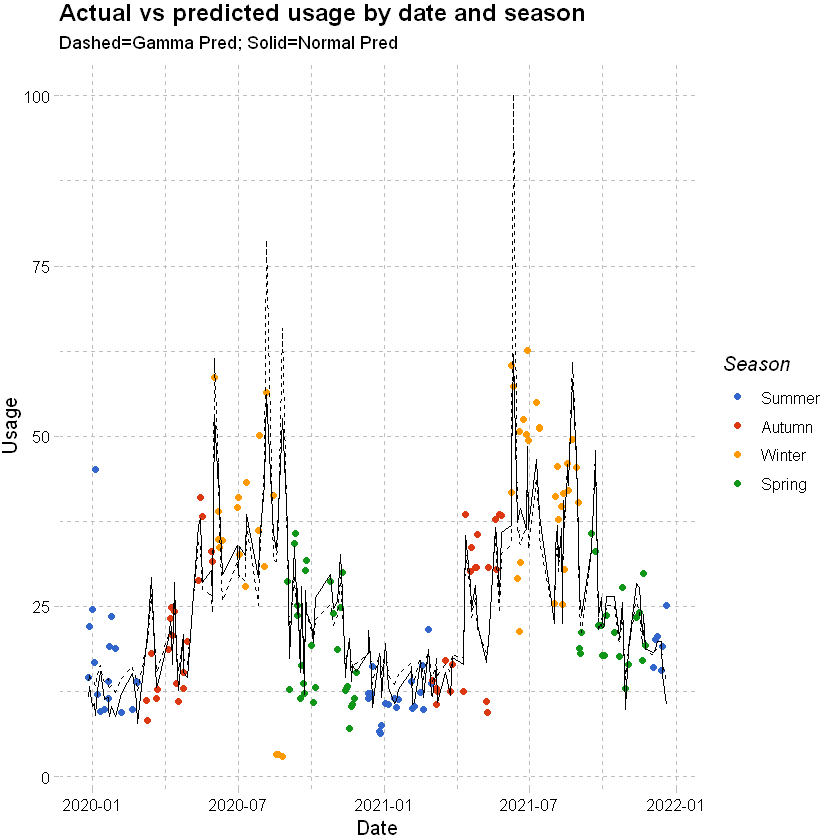

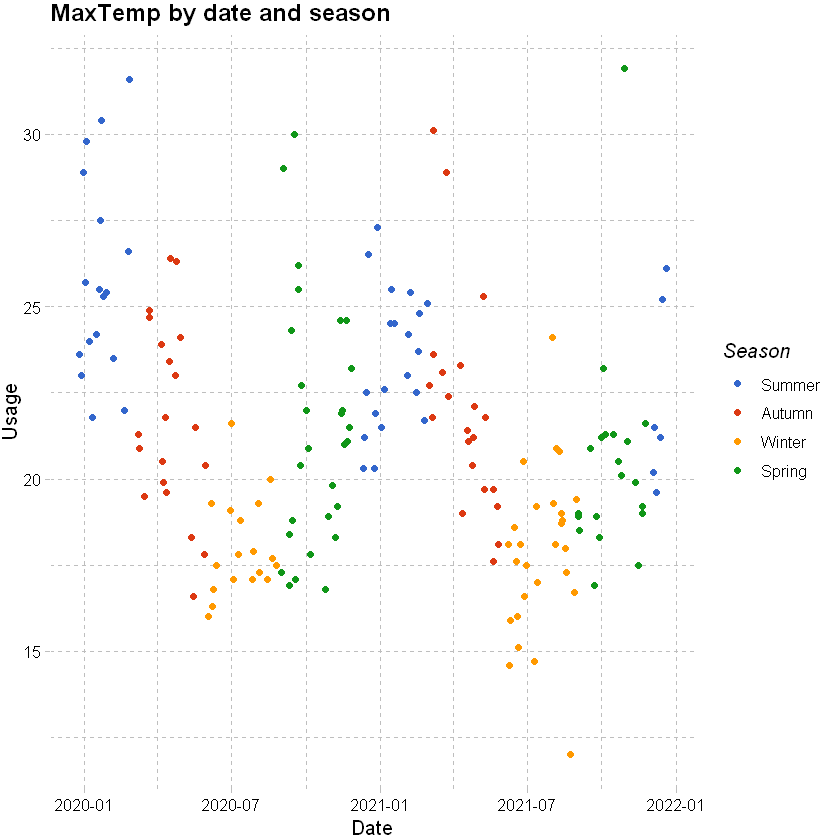

In [46]:
df_usage_test_pred  %>%
ggplot() +
geom_point(aes(x=Date,y=Usage,color=Season)) +
# add a modeled line
geom_line(aes(x=Date,y=usage_pred)) +
geom_line(aes(x=Date,y=usage_pred_gamma), linetype = "dashed") +
labs(x="Date", y="Usage", title = "Actual vs predicted usage by date and season",subtitle="Dashed=Gamma Pred; Solid=Normal Pred") +
theme_pander() + scale_color_gdocs()

# plot temperatures
df_usage_test_pred  %>%
ggplot() +
geom_point(aes(x=Date,y=MaxTemp,color=Season)) + 
labs(x="Date", y="Usage", title = "MaxTemp by date and season") +
theme_pander() + scale_color_gdocs()

Plots show slightly higher residuals at higher predicted values for the step regression model and final selected. QQ plot suggests skewness in the data, which we could see earlier in the histogram of usage. 

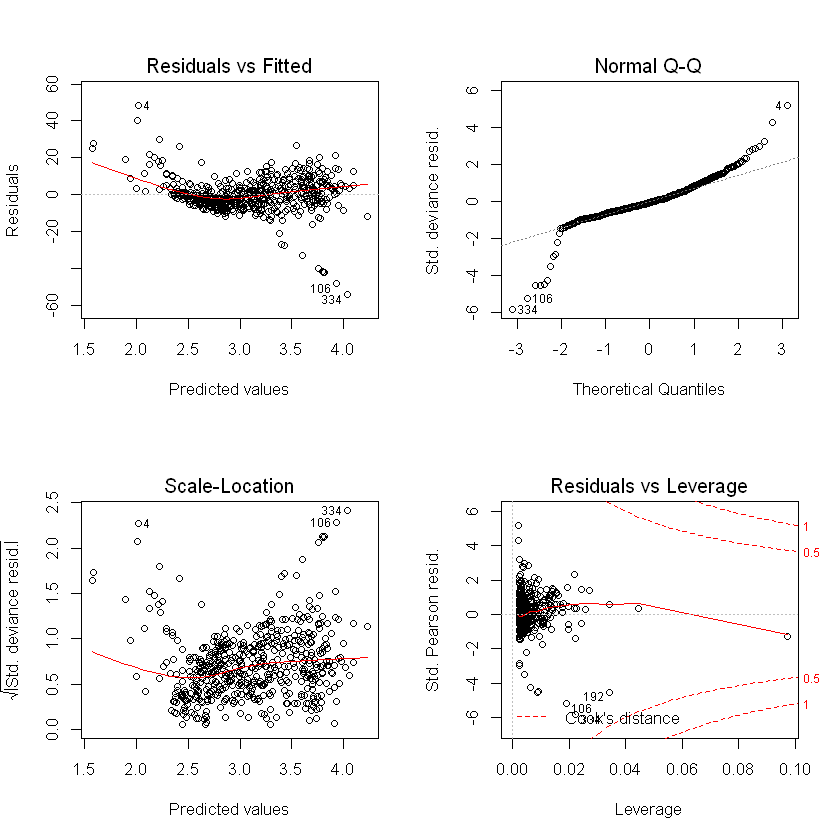

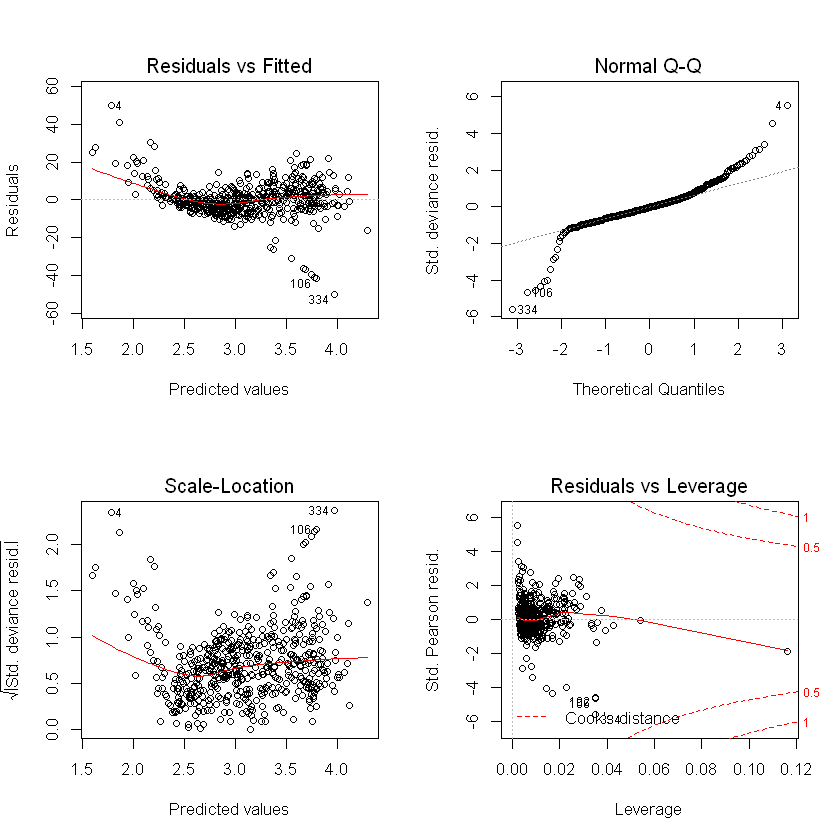

In [47]:
par(mfrow = c(2, 2))
plot(final_model_glm)
plot(step_model_glm)

Define a regression model in RJAGS. The structure here is more flexible than stan_glm which is predefined. This allows for a wider selection of prior distributions and a mixture of modeling choices. Also possible to specify model forms in this way for STAN.

$Y_i \propto N(m_i,s^2)$

Where 

* $m_i = a + bX_1i +cX_2i$  
* $a, b, c and s$ have some assumed prior distributions.

Note that the distribution syntax is slightly different to R, for example in R a normal distribution is specified using the mean and standard deviation, but in JAGS the second parameter of the dnorm command is the distribution’s precision (1 / variance).

In [48]:
usage_model <- "model{
  #Likelihood model for Y[i]
  for (i in 1:length(Y)) {
      Y[i] ~ dnorm(m[i], s^(-2)) # link=log
      log(m[i]) <- a + b*X_1[i] + c*X_2[i]
  }

  # Prior models for a, b, c, s
  a ~ dnorm(0, 0.001)     # Intercept
  b ~ dnorm(0, 0.001)     # MaxTemp
  c ~ dnorm(0, 0.001)     # MinTemp
  s ~ dunif(0, 10)        # Error

}"

Simulate from the model:

* burn-in period of 2k iterations aims for convergence and throws away these earlier test samples.
* 10k iterations for 3 chains.
* saving every 10th sample only in order to save space.

In [49]:
usage_sim <- jags.model(textConnection(usage_model),
              data=list(Y = df_usage_train$Usage, X_1 = df_usage_train$MaxTemp, X_2 = df_usage_train$MinTemp),
			        n.chains = 3)


usage_posterior <- coda.samples(usage_sim, 
                                 variable.names = c("a","b","c","s"), 
                                 n.iter = 10000, n.burnin = 2000, n.thin = 10, DIC = F)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 530
   Unobserved stochastic nodes: 4
   Total graph size: 3453

Initializing model



Summary of the results below:

* The mean of the `b` chain value was -0.040. This is an *estimate* of the posterior mean of `b`. This is consistent with the GLM above
* The corresponding *naive standard error*, 0.000253, measures the potential *error* in this estimate. This error is calculated by dividing the standard deviation of the `b` chain values by the square root of the number of iterations (or sample size). This is a *naive* approach to calculating error in a setting with dependent samples.

Also showing the density plots for the posteriors as well as the trace plots for each of the chains.


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean       SD  Naive SE Time-series SE
a  5.50682 0.102565 5.922e-04      0.0069582
b -0.04378 0.008185 4.725e-05      0.0008413
c -0.09479 0.007359 4.249e-05      0.0004640
s  9.35938 0.272236 1.572e-03      0.0020288

2. Quantiles for each variable:

      2.5%      25%      50%      75%    97.5%
a  5.31089  5.43652  5.50651  5.57561  5.71490
b -0.05971 -0.04915 -0.04370 -0.03826 -0.02738
c -0.10969 -0.09963 -0.09476 -0.08983 -0.08033
s  8.82937  9.17011  9.35979  9.55176  9.88566


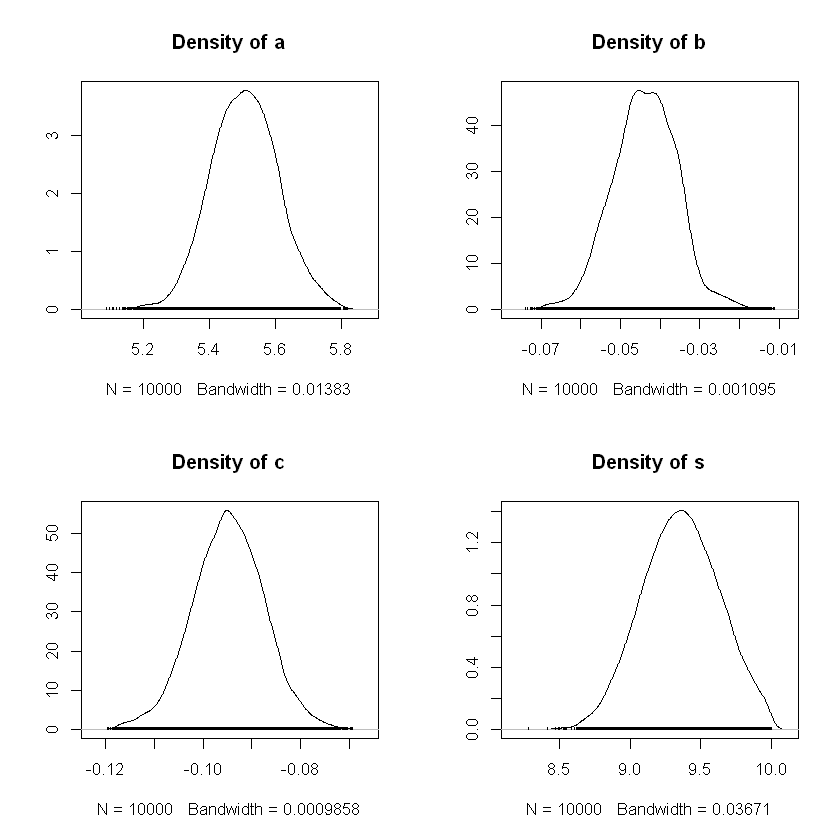

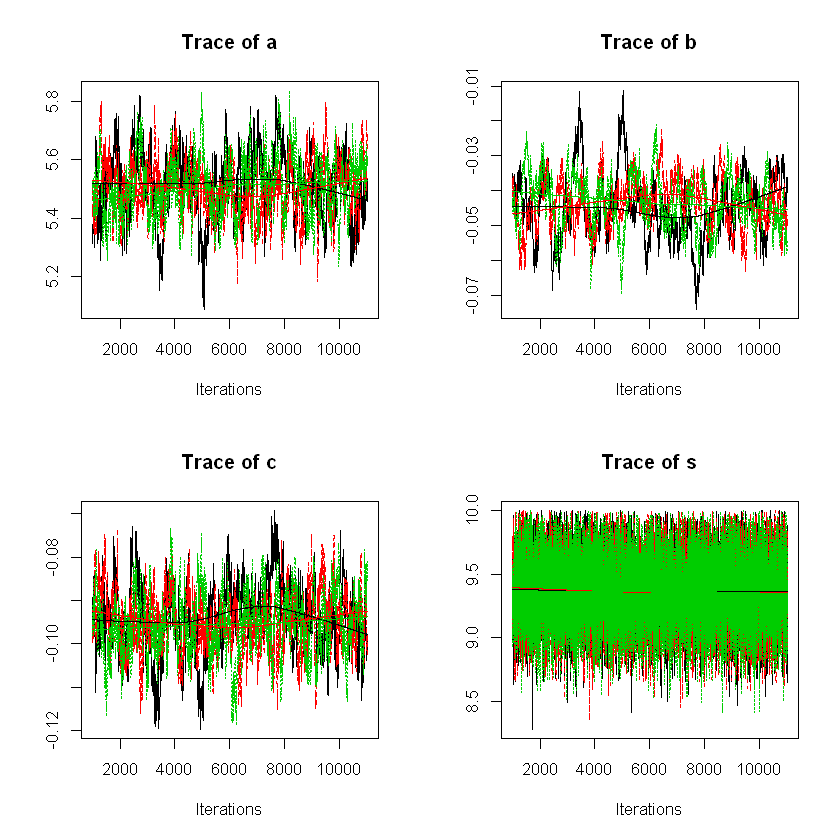

In [50]:
summary(usage_posterior)
plot(usage_posterior,trace=FALSE)
par(mfrow = c(2, 2))
plot(usage_posterior,density=FALSE)

We can plot the posterior distributions for the model parameters from the samples:

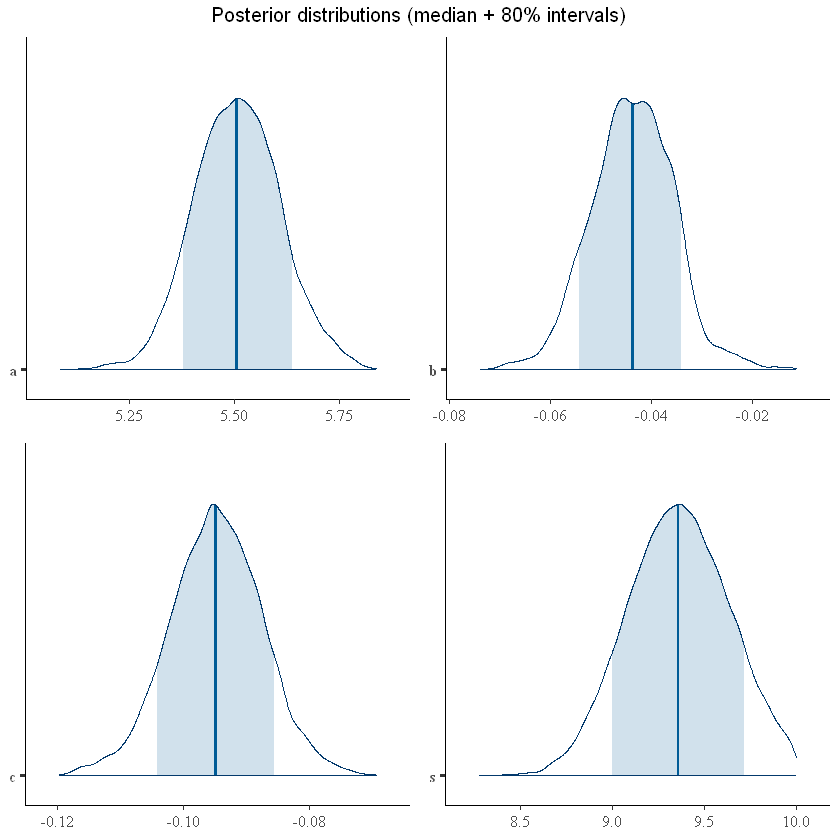

In [51]:
posterior <- as.matrix(usage_posterior)

plot1<- mcmc_areas(posterior, pars = c("a"), prob = 0.80)
plot2<- mcmc_areas(posterior, pars = c("b"), prob = 0.80)
plot3<- mcmc_areas(posterior, pars = c("c"), prob = 0.80)
plot4<- mcmc_areas(posterior, pars = c("s"), prob = 0.80)

grid.arrange(plot1,plot2, plot3, plot4, top="Posterior distributions (median + 80% intervals)")

Similar to the earlier example, we could extract the $R^2$ from the posterior distribution as well as run posterior predictive checks.

Further considerations: extracting the mean of the parameter projections, we could produce predictions for the test data. We could also produce predictions for test data point based upon each of the samples from the posterior, so above we would produce 2400 predictions for each data point (3x10k, discarding the first 2k from each chain and only saving 1/10 of the samples).

## Estimating COVID 19 infections in NSW, Australia

@Latent discusses a method of forecasting COVID infections using the package ["epinow2"](https://epiforecasts.io/EpiNow2/index.html), @Epinow. The package makes use of STAN. 

>"[Epinow2] estimates the time-varying reproduction number on cases by date of infection... Imputed infections are then mapped to observed data (for example cases by date of report) via a series of uncertain delay distributions..."

That is to say, the model makes some assumptions about lags in symptoms and in reporting (assuming some distribution for those delays) in order to estimate the true underlying number of infections (backwards). Using that backcast it projects out how those infections might be reported over time. The model also estimates the effective reproduction number in order to predict future infections.

Covid case and test data sourced from the department of [NSW Website](https://data.nsw.gov.au/) on 17/01/2022. 

We should be careful in placing too heavy a reliance on any models of incidence which are based upon case data (particularly where case rates are expected to be under reported or where testing is incomplete). The example is purely illustrative and does not attempt to correct for gaps in the data.

Case data:

In [52]:
df_cases <- read.csv(file = '../_static/bayesian_applications/confirmed_cases_table1_location.csv') 
head(df_cases)
df_tests <- read.csv(file = '../_static/bayesian_applications/pcr_testing_table1_location_agg.csv') 
head(df_tests)

# cases
df_cases <- df_cases %>% mutate(descr="cases",date=as.Date(notification_date),cases=1) %>%
filter(date > "2021-04-30",date <= "2021-12-31") %>% 
group_by(date, descr) %>% 
summarise(confirm=sum(cases)) 
head(df_cases)

notification_date,postcode,lhd_2010_code,lhd_2010_name,lga_code19,lga_name19
2020-01-25,2134,X700,Sydney,11300,Burwood (A)
2020-01-25,2121,X760,Northern Sydney,16260,Parramatta (C)
2020-01-25,2071,X760,Northern Sydney,14500,Ku-ring-gai (A)
2020-01-27,2033,X720,South Eastern Sydney,16550,Randwick (C)
2020-03-01,2077,X760,Northern Sydney,14000,Hornsby (A)
2020-03-01,2163,X710,South Western Sydney,12850,Fairfield (C)


test_date,postcode,lhd_2010_code,lhd_2010_name,lga_code19,lga_name19,test_count
2020-01-01,2038,X700,Sydney,14170,Inner West (A),1
2020-01-01,2039,X700,Sydney,14170,Inner West (A),1
2020-01-01,2040,X700,Sydney,14170,Inner West (A),2
2020-01-01,2041,X700,Sydney,14170,Inner West (A),1
2020-01-01,2069,X760,Northern Sydney,14500,Ku-ring-gai (A),1
2020-01-01,2074,X760,Northern Sydney,14500,Ku-ring-gai (A),1


`summarise()` has grouped output by 'date'. You can override using the `.groups` argument.



date,descr,confirm
2021-05-01,cases,2
2021-05-02,cases,8
2021-05-03,cases,9
2021-05-04,cases,7
2021-05-05,cases,9
2021-05-06,cases,4


Plotting recorded cases by date (PCR test outcomes only and only to 31 December 2021):

Warning message:
"Removed 1 rows containing missing values (geom_col)."


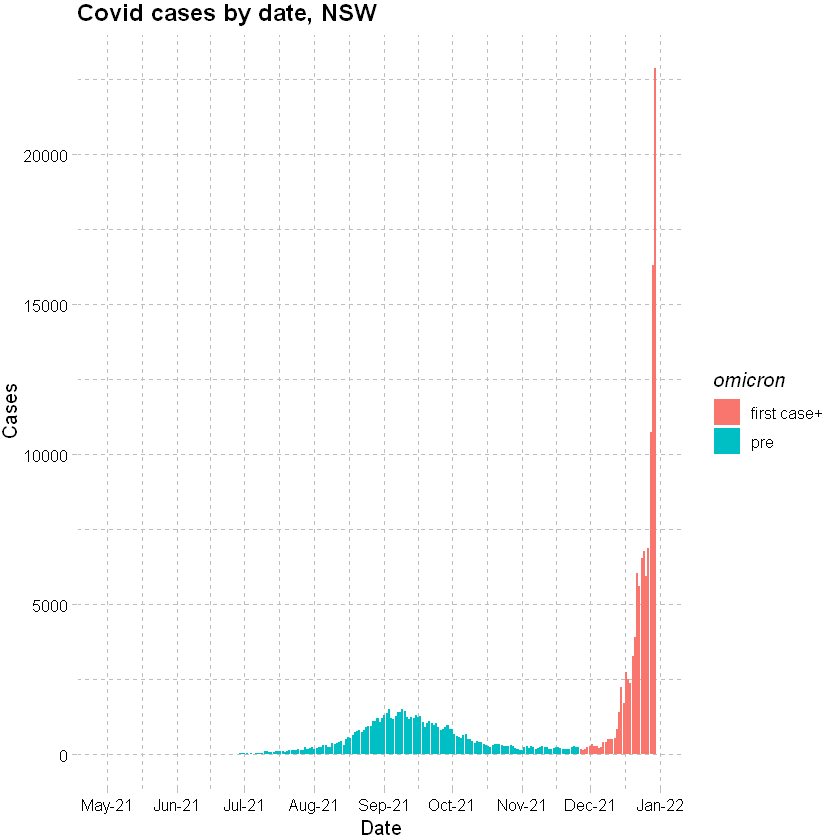

In [53]:
df_cases %>% mutate(omicron=ifelse(date > "2021-11-26","first case+","pre")) %>%
ggplot(data=., mapping = aes(x=date, y=confirm)) + 
geom_col(aes(fill=omicron)) +
scale_x_date(date_breaks = "months" , date_labels = "%b-%y", limits = c(as.Date("2021-04-30"), as.Date("2021-12-31"))) +
labs(x="Date", y="Cases", title = "Covid cases by date, NSW") +
theme_pander() + scale_color_gdocs()

Test data:

In [54]:
df_tests <- df_tests %>% mutate(descr="tests",date=as.Date(test_date)) %>%
filter(date > "2021-04-30",date <= "2021-12-31") %>% 
group_by(date, descr) %>% 
summarise(tests=sum(test_count)) 
head(df_tests)

`summarise()` has grouped output by 'date'. You can override using the `.groups` argument.



date,descr,tests
2021-05-01,tests,4514
2021-05-02,tests,4775
2021-05-03,tests,14877
2021-05-04,tests,10868
2021-05-05,tests,13126
2021-05-06,tests,24029


Plotting tests by date (PCR tests only; to 31 December 2021):

Warning message:
"Removed 1 rows containing missing values (geom_bar)."


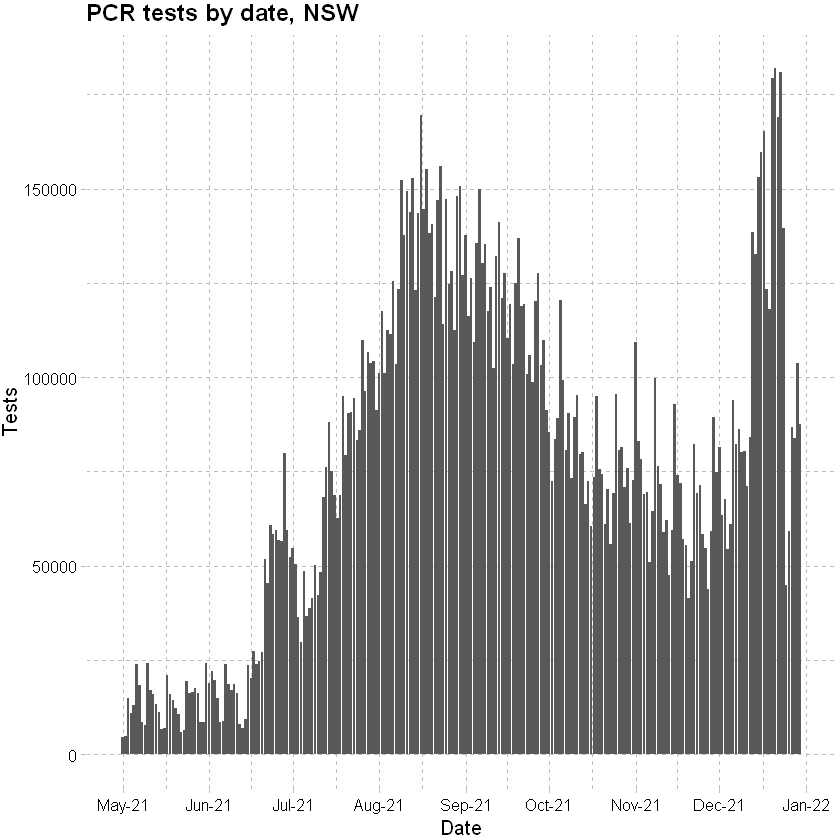

In [55]:
ggplot(data=df_tests, mapping = aes(x=date, y=tests))+ 
geom_bar(stat="identity") +
scale_x_date(date_breaks = "months" , date_labels = "%b-%y", limits = c(as.Date("2021-04-30"), as.Date("2021-12-31"))) +
labs(x="Date", y="Tests", title = "PCR tests by date, NSW") +
theme_pander() + scale_color_gdocs()

Merged to get positive test rate:

In [56]:
# merge
df <- merge(x = df_cases, y = df_tests, by = "date", all.x = TRUE) %>%
mutate(pos_rate=pmin(1, confirm/tests)) %>%
fill(pos_rate, .direction = "downup") %>%
# add smoothed positive rate
mutate(pos_rate_sm = fitted(loess(pos_rate~as.numeric(date),span=0.1))) # loess - Local Polynomial Regression Fitting; span - the parameter which controls the degree of smoothing
# drop descriptions
df$descr.x <- NULL
df$descr.y <- NULL

Plot of positive rate shows that the proportion of tests returning a positive increases to above 5% from 25th December 2021, suggesting that the case data beyond this point is less complete. 

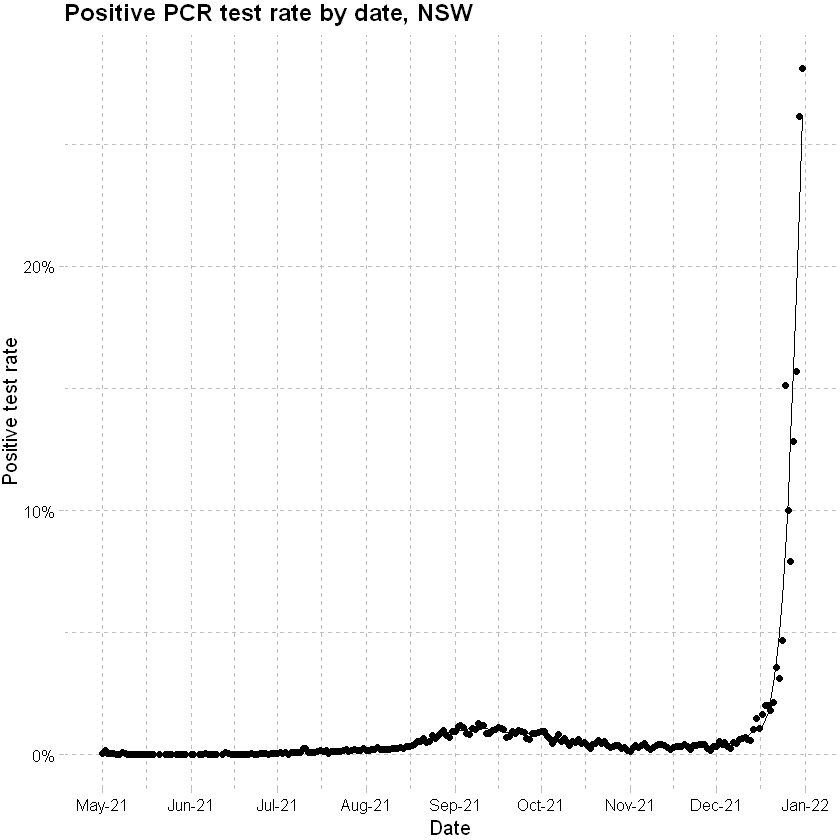

In [57]:
# positive rate
ggplot(data=df, mapping = aes(x=date))+ 
geom_point(aes(y=(pos_rate))) +
geom_line(aes(y=pos_rate_sm)) +
scale_x_date(date_breaks = "months" , date_labels = "%b-%y", limits = c(as.Date("2021-04-30"), as.Date("2021-12-31"))) +
scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
labs(x="Date", y="Positive test rate", title = "Positive PCR test rate by date, NSW") +
theme_pander() + scale_color_gdocs()


There are some pragmatic methods for adjusting the case numbers for [increasing test positivity rates](http://freerangestats.info/blog/2020/05/09/covid-population-incidence). For our purposes we will focus the model on case data before 23 December 2021 in order to exclude the period where the test data became less reliable/ complete, noting that underlying data completeness issues are likely present.

In [58]:

not_run_sample_only <- function(){# Reporting delays (delay from symptom onset to reporting/ testing positive)
reporting_delay <- estimate_delay(rlnorm(100, log(6), 1), max_value = 15)
cat("Mean reporting delay = ",reporting_delay$mean, "; ")

# Symptom generation time (time between infection events in an infector-infectee pair) and incubation period (time between moment of infection and symptom onset)
generation_time <- get_generation_time(disease = "SARS-CoV-2", source = "ganyani")
cat("Mean generation time =",generation_time$mean, "; ")
incubation_period <- get_incubation_period(disease = "SARS-CoV-2", source = "lauer")
cat("Mean incubation period =",incubation_period$mean, "; ")}


In [59]:
not_run_sample_only <- function(){
df_cases_fit <- df_cases %>% filter(date <= "2021-12-22") # exclude data before 23 December 2021

estimates <- epinow(reported_cases = df_cases_fit[c("date","confirm")], # case data from NSW
                    generation_time = generation_time,
                    delays = delay_opts(incubation_period, reporting_delay),
                    rt = rt_opts(prior = list(mean = 2, sd = 0.2)),
                    stan = stan_opts(cores = 6, samples = 3000, warmup = 500, chains = 6, control = list(adapt_delta = 0.95)))}


Importing a previous run of the above:

In [60]:
load("../_static/bayesian_applications/covid_estimates_summary.RData")

plot(estimates) produces predefined plots of cases by date reported and date of infection as well as the effective reproduction number. Given the dramatic increase in reported cases towards the end of the period, it is not surprising that the range of forecast cases is wide. Interestingly, the forecast/ partial forecast reproduction number reduces; presumably this is influenced by the earlier observations where case numbers were low. This issue has not been investigated further, however there are articles that discuss the [impact of changes to the testing procedures](https://epiforecasts.io/covid/methods.html) and other limitations.

![](../_static/bayesian_applications/covid_estimates.jpg){width=100%}
Merging forecast reported cases with the actual case data:

In [61]:
df <- merge(x = df, y = df_reported, by = "date", all.x = TRUE) %>% filter(date < "2021-12-30")

Plotting forecast vs actuals below - the week to 29 December is fully forecast from the model. Actual cases fall within the projected 90% confidence interval range, noting that the test positivity rate increased materially from 25th December so it is likely that the actual cases are under reported. 

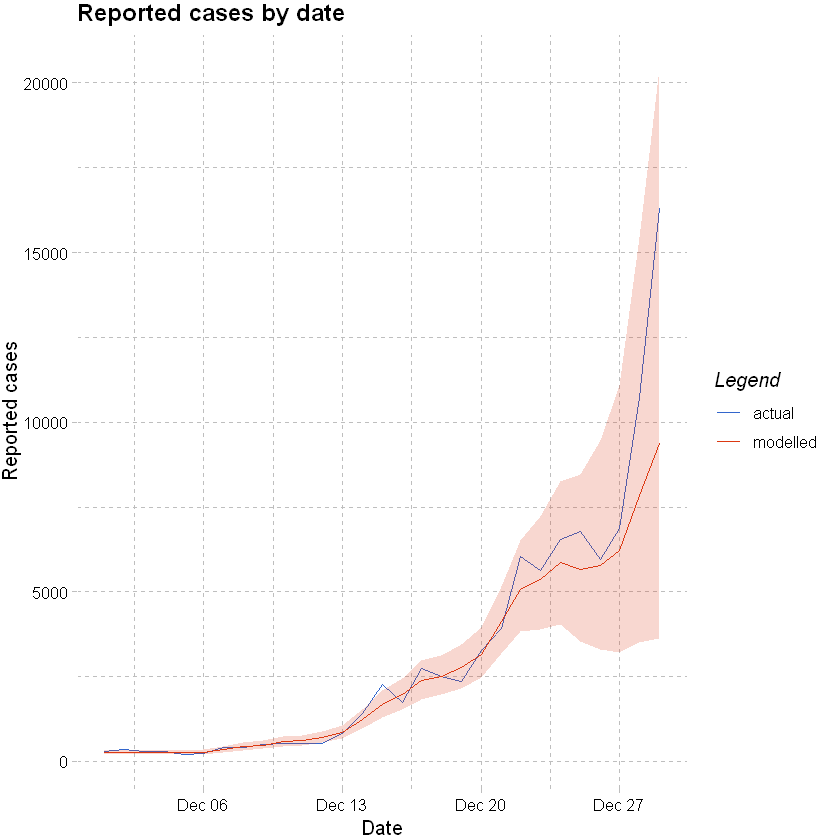

In [62]:

colours <- c("actual" = "#3366cc","modelled" = "#dc3912")

ggplot(data=df %>% filter(date >= "2021-12-01"), aes(x=date)) +
geom_line(aes(y=confirm, color="actual")) +
geom_line(aes(y=mean,color="modelled")) +
geom_ribbon(aes(ymin=lower_90, ymax=upper_90), fill="#dc3912", alpha=0.2) +
labs(x="Date", y="Reported cases", title = "Reported cases by date",color="Legend") +
scale_color_manual(values = colours) +
theme_pander()

# Common issues in MCMC projections

* Divergent transitions: Common fix is changing the step size using the adapt_delta argument in STAN.
* Exceeding maximum tree depth: the is a point of efficiency. See notes [here](https://mc-stan.org/misc/warnings.html) for assistance in STAN and other potential warnings.

# Further reading
A few books and articles of interest on STAN: 

* [STAN documentation](https://mc-stan.org/users/documentation/)
* [STAN linear regression model](https://m-clark.github.io/bayesian-basics/models.html)
* [Applied Bayesian Inference in r using STAN](https://www.r-bloggers.com/2020/01/applied-bayesian-statistics-using-stan-and-r/)
* [Prior selections - STAN package](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations)
* [JAGS user manual](https://people.stat.sc.edu/hansont/stat740/jags_user_manual.pdf)